# CNN(Convolutional Neural Network)

## 공통 코드

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version은 코랩 명령입니다.
    %tensorflow_version 2.x
except Exception:
    pass

# 이 노트북은 텐서플로 ≥2.4이 필요합니다
# 2.x 버전은 대부분 동일한 결과를 만들지만 몇 가지 버그가 있습니다.
import tensorflow as tf
from tensorflow import keras
#assert tf.__version__ >= "2.4"

# 공통 모듈 임포트
import numpy as np
import pandas as pd

import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
tf.random.set_seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "CNN"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

import warnings
warnings.filterwarnings(action='ignore')

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
No GPU was detected. CNNs can be very slow without a GPU.
Go to Runtime > Change runtime and select a GPU hardware accelerator.


## CNN

### 합성곱 구현

In [3]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

In [4]:
! pip install Pillow

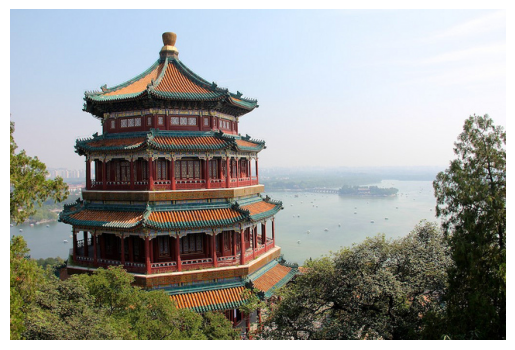

In [5]:
import PIL.Image as Image
#이미지 가져오기 및 출력
china = np.array(Image.open("/content/drive/MyDrive/DX school/0916_Data/china.jpg")) / 255
flower = np.array(Image.open("/content/drive/MyDrive/DX school/0916_Data/flower.jpg")) / 255
images = np.array([china, flower])
plt.imshow(china)
plt.axis("off")
plt.show()

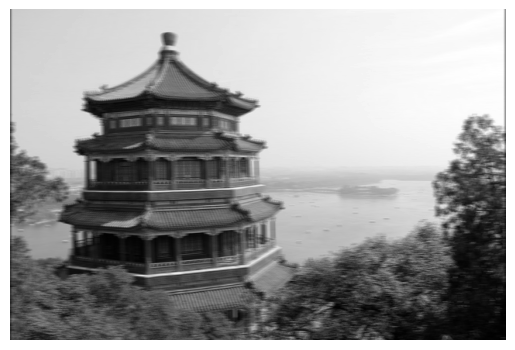

In [6]:
import numpy as np
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# Create 2 filters
# 필터는 입력 데이터와 연산에 사용할 행렬
# 홀수의 정방 행렬로 만들고 특정 방향으로만 1을 설정하고 나머지는 0
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

#합성 곱 층에 대입
#첫번째가 입력 데이터, 두번째가 필터
#세번째 : 스트라이드(보폭), 네번째 : 패딩 여부
#입력은 4D 텐서 - 미니 배치 형식
#필터도 4D 텐서
#strides는 1이나 4개의 원소를 갖는 1D 배열
#첫번째와 네번째는 1, 두번째와 세번째 요소가 수직 수평 스트라이드
#padding은 SAME(패딩 사용)이나 VALID(패딩 사용X)
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

# 결과 출력
plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.axis("off")
plt.show()

In [ ]:
#컬러 : 3채널
images.shape

(2, 427, 640, 3)

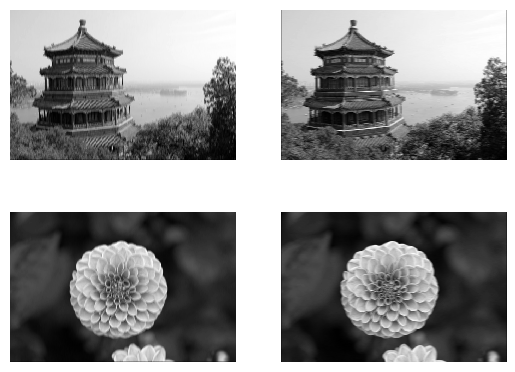

In [ ]:
#이미지 출력
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

그림 저장: china_original


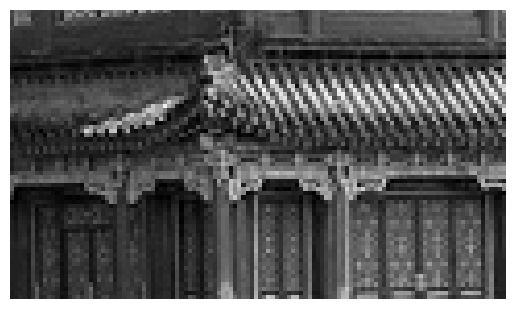

그림 저장: china_vertical


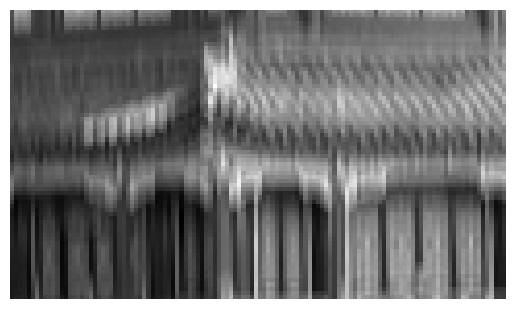

그림 저장: china_horizontal


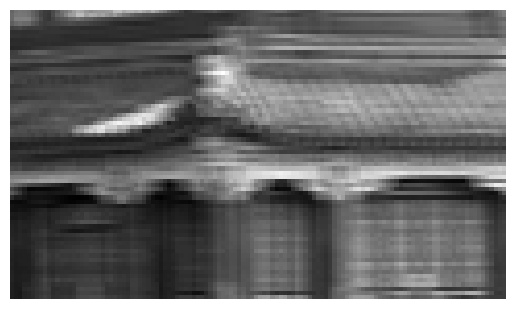

In [ ]:
def crop(images):
    return images[150:220, 130:250]

plot_image(crop(images[0, :, :, 0]))
save_fig("china_original", tight_layout=False)
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    save_fig(filename, tight_layout=False)
    plt.show()

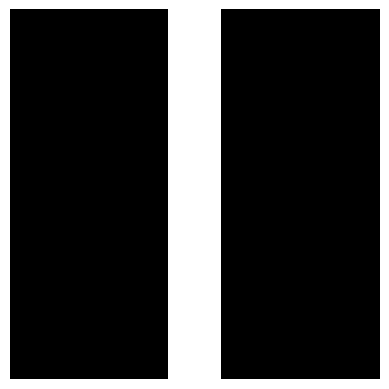

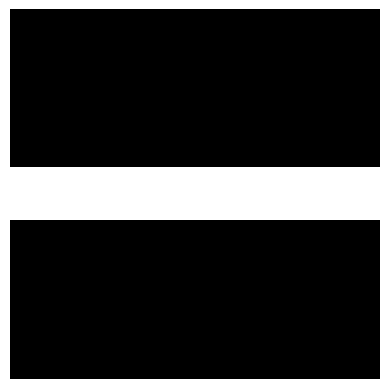

In [ ]:
# 필터 확인
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()

### Conv2D 에 필터 적용

In [ ]:
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,
                           padding="SAME", activation="relu")

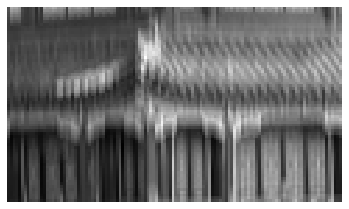

In [ ]:
plot_image(crop(outputs[0, :, :, 0]))
plt.show()

### Pooling Layer

#### Max Pooling

In [ ]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [ ]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

그림 저장: china_max_pooling


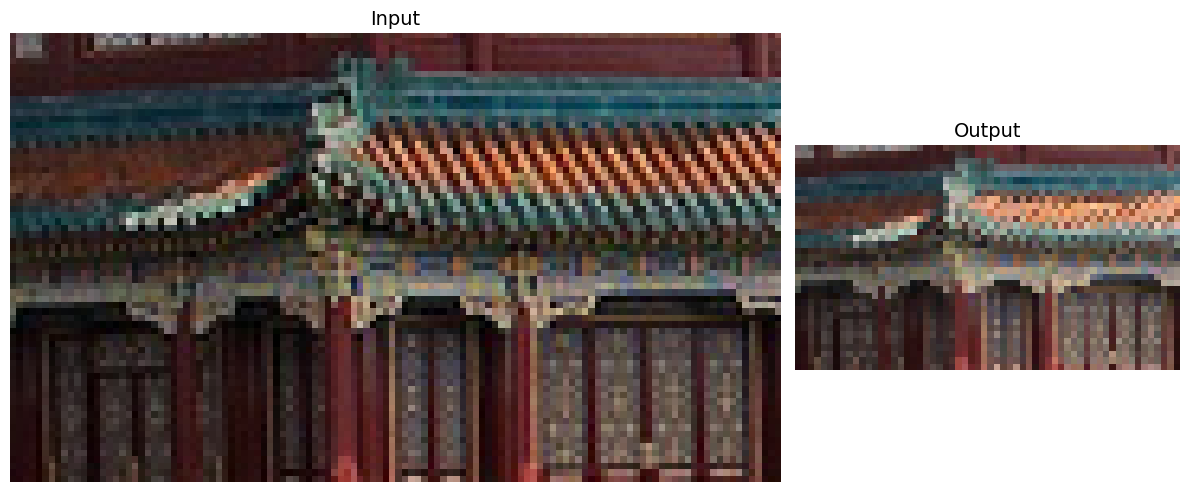

In [ ]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
save_fig("china_max_pooling")
plt.show()

#### Average Pooling

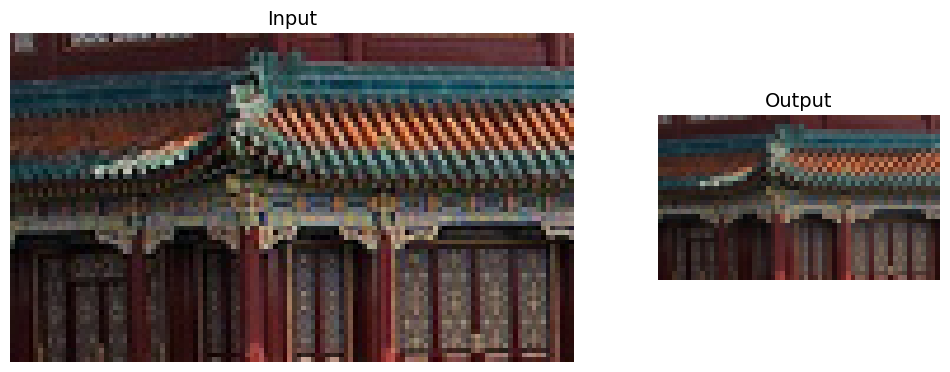

In [ ]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)

output_avg = avg_pool(cropped_images)

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

#### Depth-wise pooling

In [ ]:
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding="VALID", **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
    def call(self, inputs):
        return tf.nn.max_pool(inputs,
                              ksize=(1, 1, 1, self.pool_size),
                              strides=(1, 1, 1, self.pool_size),
                              padding=self.padding)

In [ ]:
depth_pool = DepthMaxPool(3)
with tf.device("/cpu:0"): # there is no GPU-kernel yet
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

In [ ]:
depth_pool = keras.layers.Lambda(lambda X: tf.nn.max_pool(
    X, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding="VALID"))
with tf.device("/cpu:0"): # there is no GPU-kernel yet
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

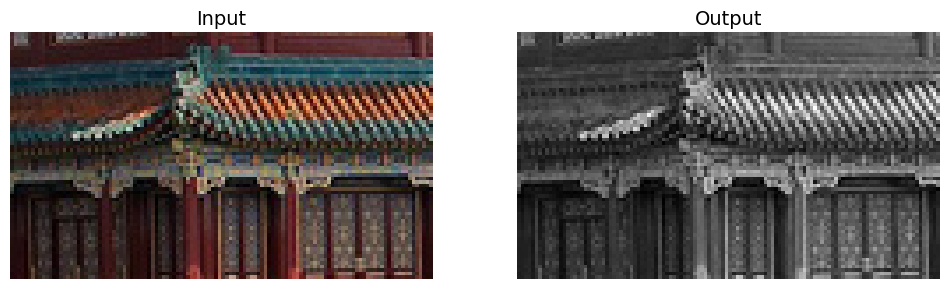

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])  # plot the 1st image
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[0, ..., 0])  # plot the output for the 1st image
plt.axis("off")
plt.show()

#### Global Average Pooling Layer

In [ ]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.45952484, 0.3342377 ]], dtype=float32)>

In [ ]:
output_global_avg2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))
output_global_avg2(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.45952484, 0.3342377 ]], dtype=float32)>

### 합성곱 신경망을 이용한 패션 이미지 분류

#### 데이터 불러오기

In [ ]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()

train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

4422102/4422102 [==============================] - 0s 0us/step


#### 합성곱 신경망 만들기

In [ ]:
model = keras.Sequential()

# 28, 28 은 이미지 크기, 1은 흑백이니까
# 32 = filter(커널)의 개수 (랜덤하게 다양한 방향으로 생성해줌)
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same',
                              input_shape=(28,28,1)))

model.add(keras.layers.MaxPooling2D(2))

model.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D(2))

# Dense 전에는 1차원으로 만드는 작업이 필요함 -> 1차원 Layer 생성
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu'))
#Dropout은 사용할 뉴런을 랜덤하게 추출하기 위한 레이어
#제거할 비율을 설정 - 0.4로 하면 60%만 제거 ?
model.add(keras.layers.Dropout(0.4))
#출력 층 - 뉴런의 개수가 1 또는 분류할 클래스의 개수
#분류는 출력의 activation이 softmax
model.add(keras.layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 3136)              0         
                                                                 
 dense_2 (Dense)             (None, 100)              

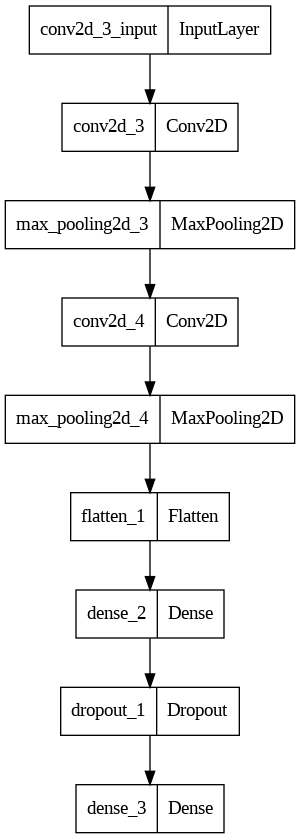

In [ ]:
keras.utils.plot_model(model)

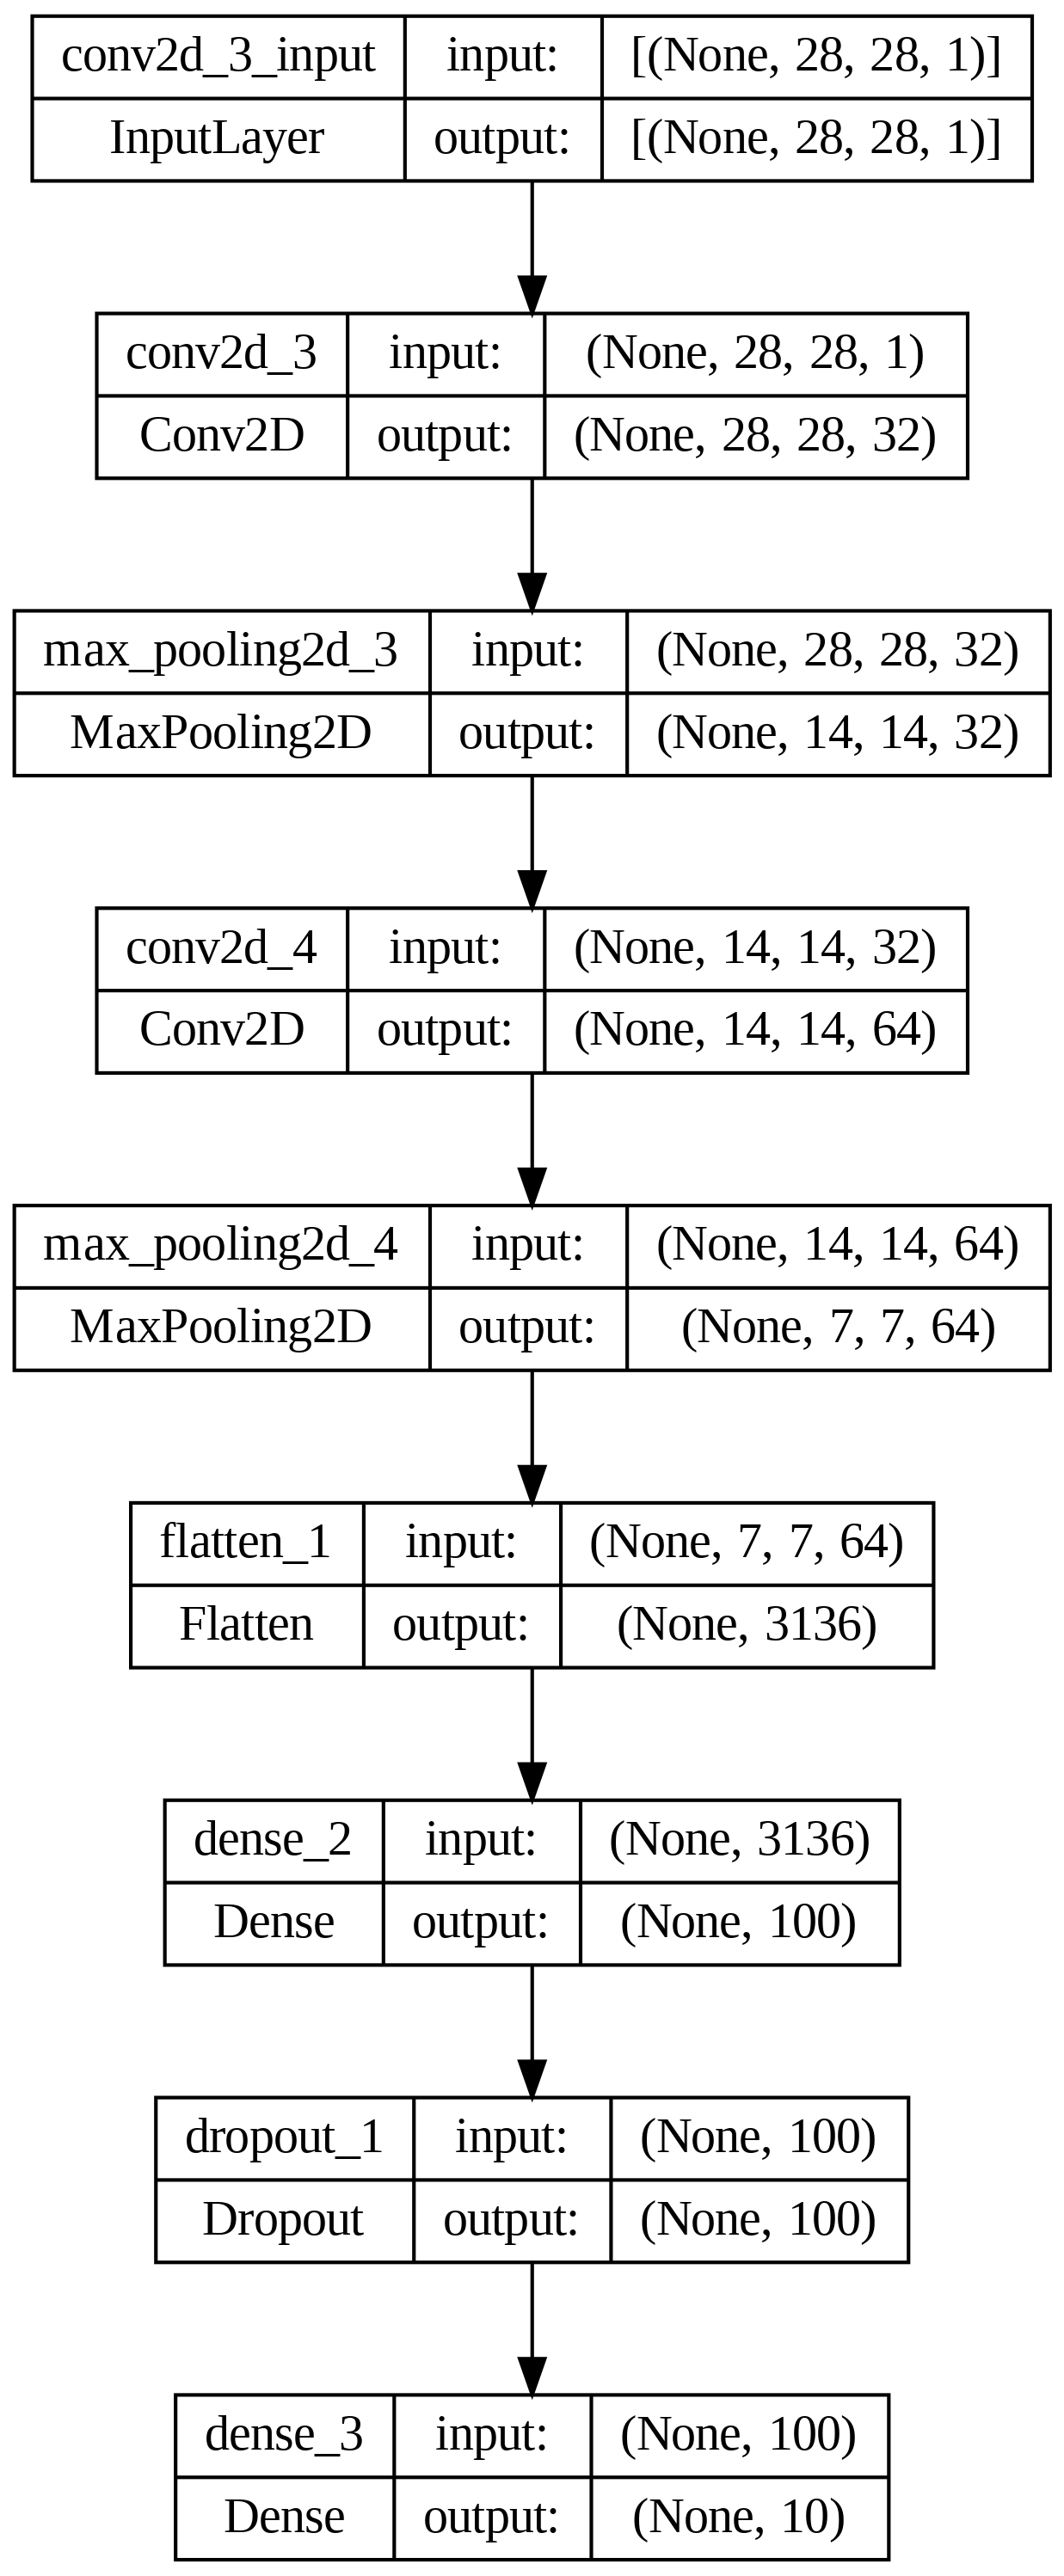

In [ ]:
keras.utils.plot_model(model, show_shapes=True, to_file='cnn-architecture.png', dpi=300)

#### 모델 컴파일 과 훈련

In [ ]:
# 컴파일 - 최적화 함수는 adam
# loss는 손실함수
# metrics는 평가 지표
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

# callback은 이벤트가 발생할 때마다 호출되는 함수나 객체
# 하나의 epoch 마다 체크하기 위한 부분
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5')
# 2번 이상 평가 지표가 좋아지지 않으면 조기 종료(patience)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)
# 실제 훈
history = model.fit(train_scaled, train_target, epochs=20,
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])


Epoch 1/20
1500/1500 [==============================] - 48s 31ms/step - loss: 0.1814 - accuracy: 0.9344 - val_loss: 0.2214 - val_accuracy: 0.9232
Epoch 2/20
1500/1500 [==============================] - 48s 32ms/step - loss: 0.1652 - accuracy: 0.9385 - val_loss: 0.2266 - val_accuracy: 0.9225
Epoch 3/20
1500/1500 [==============================] - 45s 30ms/step - loss: 0.1509 - accuracy: 0.9440 - val_loss: 0.2346 - val_accuracy: 0.9212


#### 손실 함수 출력

Exception ignored in: <function _xla_gc_callback at 0x79f099217be0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


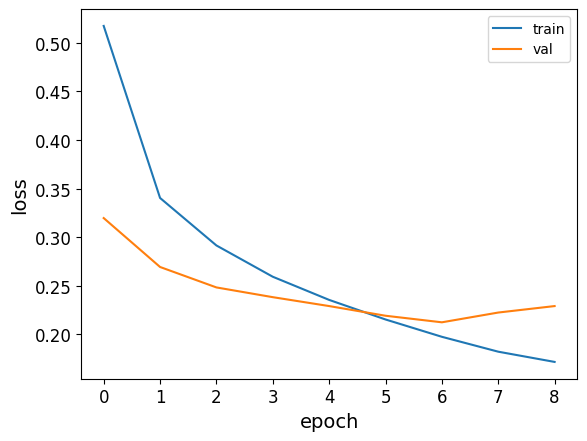

In [ ]:
# val을 볼 때는 반정도 밀어서 봐야됨
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

#### 모델 평가 와 예측

In [ ]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 5s 12ms/step - loss: 0.2214 - accuracy: 0.9232


[0.2214118242263794, 0.9231666922569275]

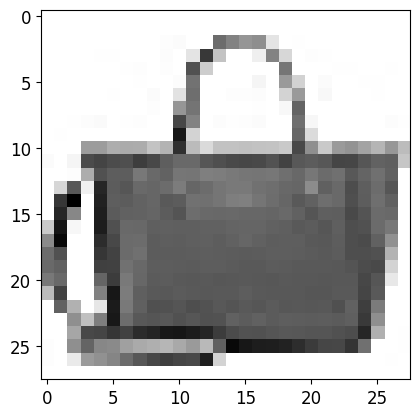

In [ ]:
plt.imshow(val_scaled[0].reshape(28, 28), cmap='gray_r')
plt.show()

In [ ]:
preds = model.predict(val_scaled[0:1])
print(preds)

1/1 [==============================] - 0s 93ms/step
[[6.0869662e-20 5.4315861e-28 1.1418042e-24 6.3116607e-24 3.0783100e-25
  1.2431131e-19 9.5679432e-24 6.7518924e-18 1.0000000e+00 1.3525900e-22]]


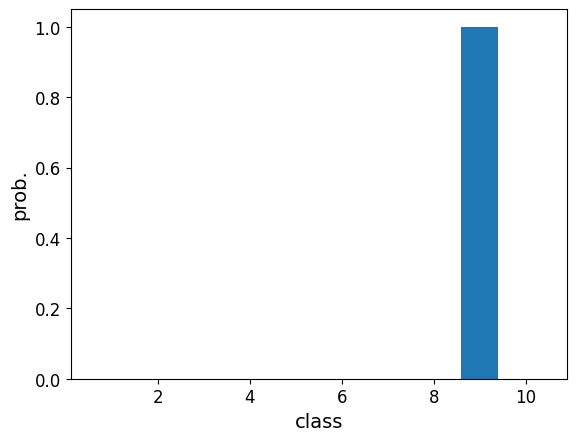

In [ ]:
plt.bar(range(1, 11), preds[0])
plt.xlabel('class')
plt.ylabel('prob.')
plt.show()

In [ ]:
classes = ['티셔츠', '바지', '스웨터', '드레스', '코트',
           '샌달', '셔츠', '스니커즈', '가방', '앵클 부츠']

In [ ]:
import numpy as np
print(classes[np.argmax(preds)])

가방


In [ ]:
test_scaled = test_input.reshape(-1, 28, 28, 1) / 255.0

In [ ]:
model.evaluate(test_scaled, test_target)

313/313 [==============================] - 4s 12ms/step - loss: 0.2428 - accuracy: 0.9174


[0.2428322583436966, 0.9174000024795532]

In [ ]:
# 최고의 모델을 저장하는데, 가중치까지 저장해주기 때문에 새로운 데이터가 들어오면 새로운 데이터만 학습하면 됨
model.save('best-cnn-model.h5')

### 합성곱 신경망의 시각화

#### 이전 모델 가져오기

In [ ]:
model = keras.models.load_model('best-cnn-model.h5')

In [ ]:
model.layers

#### 가중치 확인

In [ ]:
# 3*3은 커널의 사이즈, 1은 채널의 개수, 32는 커널의 개수
conv = model.layers[0]

print(conv.weights[0].shape, conv.weights[1].shape)

(3, 3, 1, 32) (32,)


In [ ]:
conv_weights = conv.weights[0].numpy()

print(conv_weights.mean(), conv_weights.std())

-0.029126005 0.24895848


#### 가중치 분포 확인

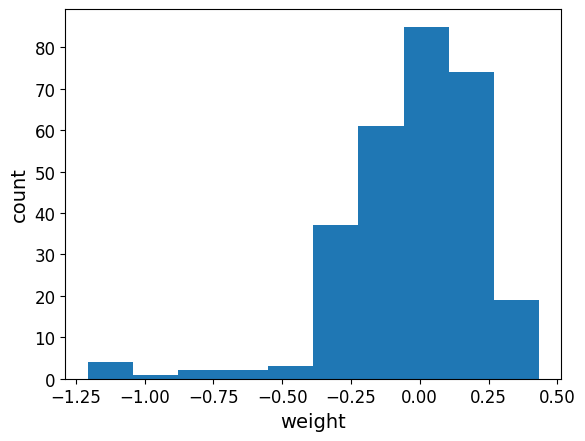

In [ ]:
import matplotlib.pyplot as plt

plt.hist(conv_weights.reshape(-1, 1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

#### 32개 커널을 16개씩 출력

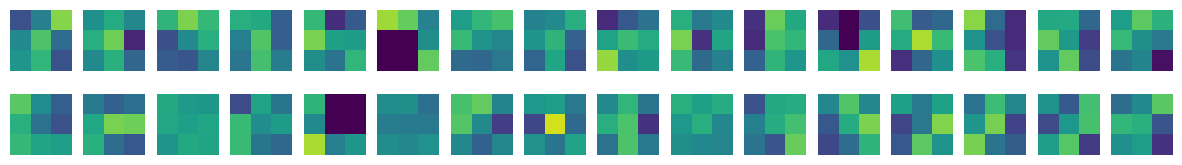

In [ ]:
fig, axs = plt.subplots(2, 16, figsize=(15,2))

for i in range(2):
    for j in range(16):
        axs[i, j].imshow(conv_weights[:,:,0,i*16 + j], vmin=-0.5, vmax=0.5)
        axs[i, j].axis('off')

plt.show()

#### 훈련하지 않은 빈 신경망 생성

In [ ]:
no_training_model = keras.Sequential()

no_training_model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu',
                                          padding='same', input_shape=(28,28,1)))

#### 첫번째 층의 가중치를 저장

In [ ]:
no_training_conv = no_training_model.layers[0]

print(no_training_conv.weights[0].shape)

(3, 3, 1, 32)


#### 가중치의 평균 과 표준편차

In [ ]:
no_training_weights = no_training_conv.weights[0].numpy()

print(no_training_weights.mean(), no_training_weights.std())

-0.0015809602 0.08384947


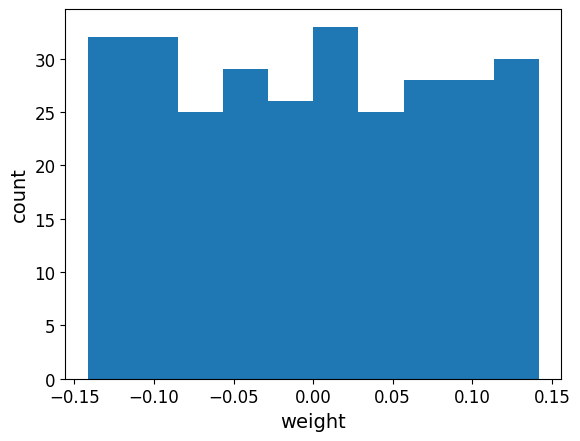

In [ ]:
plt.hist(no_training_weights.reshape(-1, 1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

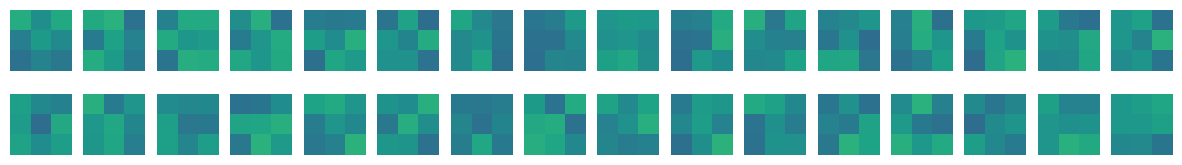

In [ ]:
fig, axs = plt.subplots(2, 16, figsize=(15,2))

for i in range(2):
    for j in range(16):
        axs[i, j].imshow(no_training_weights[:,:,0,i*16 + j], vmin=-0.5, vmax=0.5)
        axs[i, j].axis('off')

plt.show()

### 함수형 API 사용

In [ ]:
conv_acti = keras.models.Model(model.input, model.layers[0].output)

#### 특성 맵 시각화

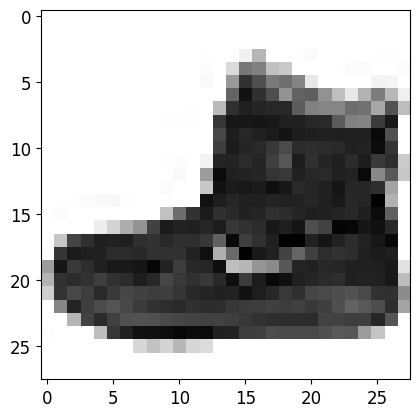

In [ ]:
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()

plt.imshow(train_input[0], cmap='gray_r')
plt.show()

In [ ]:
inputs = train_input[0:1].reshape(-1, 28, 28, 1)/255.0
feature_maps = conv_acti.predict(inputs)
print(feature_maps.shape)

1/1 [==============================] - 0s 58ms/step
(1, 28, 28, 32)


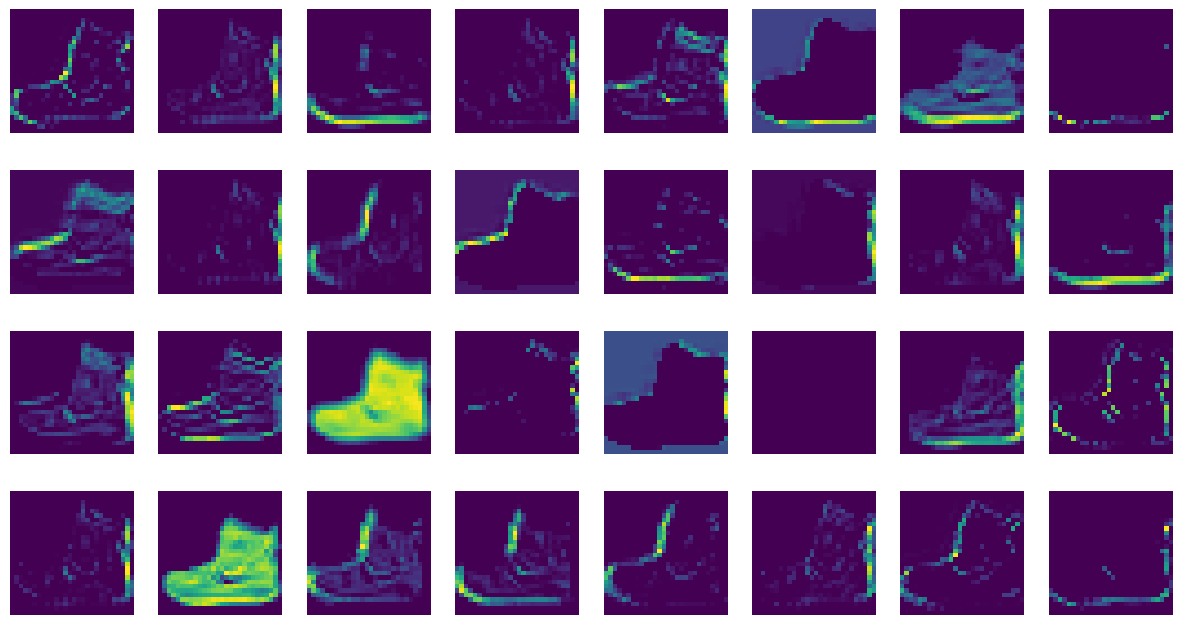

In [ ]:
fig, axs = plt.subplots(4, 8, figsize=(15,8))

for i in range(4):
    for j in range(8):
        axs[i, j].imshow(feature_maps[0,:,:,i*8 + j])
        axs[i, j].axis('off')

plt.show()

(1, 14, 14, 64)


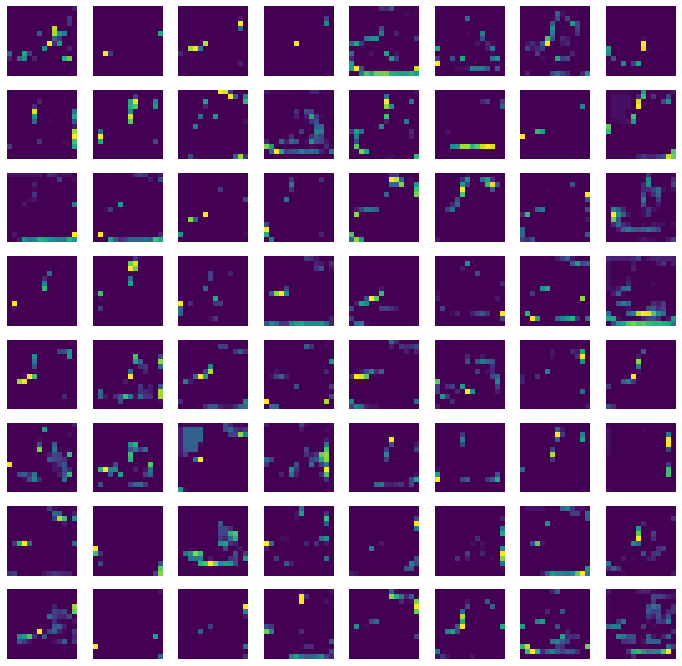

In [ ]:
# 함수형
conv2_acti = keras.models.Model(model.input, model.layers[2].output)

feature_maps = conv2_acti.predict(train_input[0:1].reshape(-1, 28, 28, 1)/255.0)

print(feature_maps.shape)

fig, axs = plt.subplots(8, 8, figsize=(12,12))

for i in range(8):
    for j in range(8):
        axs[i, j].imshow(feature_maps[0,:,:,i*8 + j])
        axs[i, j].axis('off')

plt.show()

## CNN 을 활용한 교통 표지판 인식

### 데이터 가져오고 전처리

In [ ]:
N_CLASSES = 43
RESIZED_IMAGE = (32, 32)

import matplotlib.pyplot as plt
import glob
from skimage.color import rgb2lab
from skimage.transform import resize
from collections import namedtuple
import numpy as np
np.random.seed(101)
%matplotlib inline

Dataset = namedtuple('Dataset', ['X', 'y'])

def to_tf_format(imgs):
    return np.stack([img[:, :, np.newaxis] for img in imgs], axis=0).astype(np.float32)

def read_dataset_ppm(rootpath, n_labels, resize_to):
  images = []
  labels = []

  for c in range(n_labels):
    full_path = rootpath + '/' + format(c, '05d') + '/'
    for img_name in glob.glob(full_path + "*.ppm"):

      img = plt.imread(img_name).astype(np.float32)
      img = rgb2lab(img / 255.0)[:,:,0]
      if resize_to:
        img = resize(img, resize_to, mode='reflect')

      label = np.zeros((n_labels, ), dtype=np.float32)
      label[c] = 1.0

      images.append(img.astype(np.float32))
      labels.append(label)

  return Dataset(X = to_tf_format(images).astype(np.float32),
                 y = np.matrix(labels).astype(np.float32))

dataset = read_dataset_ppm('./data/GTSRB/Final_Training/Images', N_CLASSES, RESIZED_IMAGE)
print(dataset.X.shape)
print(dataset.y.shape)

(39209, 32, 32, 1)
(39209, 43)


### 이미지 출력

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


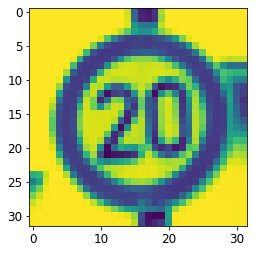

In [ ]:
plt.imshow(dataset.X[0, :, :, :].reshape(RESIZED_IMAGE)) #sample
print(dataset.y[0, :]) #label

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


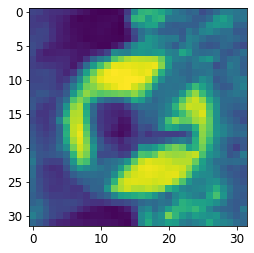

In [ ]:
plt.imshow(dataset.X[-1, :, :, :].reshape(RESIZED_IMAGE)) #sample
print(dataset.y[-1, :]) #label

### 훈련 데이터 와 테스트 데이터 생성

In [ ]:
from sklearn.model_selection import train_test_split
idx_train, idx_test = train_test_split(range(dataset.X.shape[0]), test_size=0.25, random_state=101)
X_train = dataset.X[idx_train, :, :, :]
X_test = dataset.X[idx_test, :, :, :]
y_train = dataset.y[idx_train, :]
y_test = dataset.y[idx_test, :]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

ar = []


ar = []
for i in np.asarray(y_train):
    for k, j in enumerate(i):
       if j == 1:
            ar.append(k)
y_train = np.array(ar)

ar = []
for i in np.asarray(y_test):
    for k, j in enumerate(i):
       if j == 1:
            ar.append(k)
y_test = np.array(ar)

(29406, 32, 32, 1)
(29406, 43)
(9803, 32, 32, 1)
(9803, 43)


### 신경망 생성

In [ ]:
model = keras.Sequential()

model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same',
                              input_shape=(32,32,1)))

model.add(keras.layers.MaxPooling2D(2))

model.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D(2))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.4))

model.add(keras.layers.Dense(43, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 4096)              0         
                                                                 
 dense_2 (Dense)             (None, 100)              

### 모델 훈련

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=20,
                    callbacks=[checkpoint_cb, early_stopping_cb])


Epoch 1/20
919/919 [==============================] - 16s 17ms/step - loss: 3.6741 - accuracy: 0.0551
Epoch 2/20
919/919 [==============================] - 17s 19ms/step - loss: 3.5263 - accuracy: 0.0572
Epoch 3/20
919/919 [==============================] - 16s 18ms/step - loss: 3.4971 - accuracy: 0.0567
Epoch 4/20
919/919 [==============================] - 17s 18ms/step - loss: 3.4897 - accuracy: 0.0578
Epoch 5/20
919/919 [==============================] - 17s 18ms/step - loss: 3.4876 - accuracy: 0.0566
Epoch 6/20
919/919 [==============================] - 17s 19ms/step - loss: 3.4872 - accuracy: 0.0573
Epoch 7/20
919/919 [==============================] - 17s 19ms/step - loss: 3.4869 - accuracy: 0.0555
Epoch 8/20
919/919 [==============================] - 16s 17ms/step - loss: 3.4867 - accuracy: 0.0562
Epoch 9/20
919/919 [==============================] - 16s 18ms/step - loss: 3.4864 - accuracy: 0.0566
Epoch 10/20
919/919 [==============================] - 16s 17ms/step - loss: 3.486

## CNN을 활용한 MNIST 이미지 분류

### Sequential API를 이용한 이미지 분류

#### 데이터 가져오기

In [ ]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_valid, y_valid) = mnist.load_data()

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


#### 샘플 이미지 출력

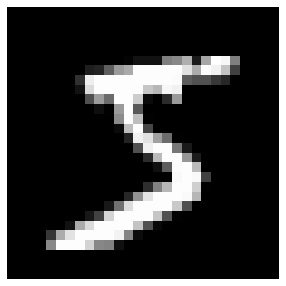

In [ ]:
import matplotlib.pylab as plt

def plot_image(data, idx):
    plt.figure(figsize=(5, 5))
    plt.imshow(data[idx], cmap="gray")
    plt.axis("off")
    plt.show()

plot_image(x_train, 0)

#### 값의 범위 확인

In [ ]:
print(x_train.min(), x_train.max())
print(x_valid.min(), x_valid.max())

0 255
0 255


#### 정규화

In [ ]:
x_train = x_train / 255.0
x_valid = x_valid / 255.0

print(x_train.min(), x_train.max())
print(x_valid.min(), x_valid.max())

0.0 1.0
0.0 1.0


#### 채널 추가

In [ ]:
# 채널 추가
print(x_train.shape, x_valid.shape)

#4차원 텐서를 만들기 위한 변환
x_train_in = x_train[..., tf.newaxis]
x_valid_in = x_valid[..., tf.newaxis]
#(개수, 가로, 세로, 채널의 개)
print(x_train_in.shape, x_valid_in.shape)

(60000, 28, 28) (10000, 28, 28)
(60000, 28, 28, 1) (10000, 28, 28, 1)


#### CNN 생성

In [ ]:
# Sequential API를 사용하여 샘플 모델 생성
model = tf.keras.Sequential([
    # Convolution 적용 (32 filters)
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                           input_shape=(28, 28, 1), name='conv'),
    # Max Pooling 적용
    tf.keras.layers.MaxPooling2D((2, 2), name='pool'),
    # Classifier 출력층
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax'),
])

#### 모델 컴파일 및 훈련

In [ ]:
# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
history = model.fit(x_train_in, y_train,
                    validation_data=(x_valid_in, y_valid),
                    epochs=10)

Epoch 1/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2137 - accuracy: 0.9390 - val_loss: 0.0941 - val_accuracy: 0.9714
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0778 - accuracy: 0.9779 - val_loss: 0.0643 - val_accuracy: 0.9794
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0585 - accuracy: 0.9828 - val_loss: 0.0549 - val_accuracy: 0.9823
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0479 - accuracy: 0.9852 - val_loss: 0.0541 - val_accuracy: 0.9820
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0403 - accuracy: 0.9877 - val_loss: 0.0537 - val_accuracy: 0.9833
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0342 - accuracy: 0.9899 - val_loss: 0.0537 - val_accuracy: 0.9837
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0296 - accuracy: 0.9912 - val_loss: 0.0509 - val_accuracy:

#### 모델 평가

In [ ]:
model.evaluate(x_valid_in, y_valid)

313/313 [==============================] - 1s 2ms/step - loss: 0.0576 - accuracy: 0.9833


[0.057565320283174515, 0.983299970626831]

#### 손실과 정밀도 그래프

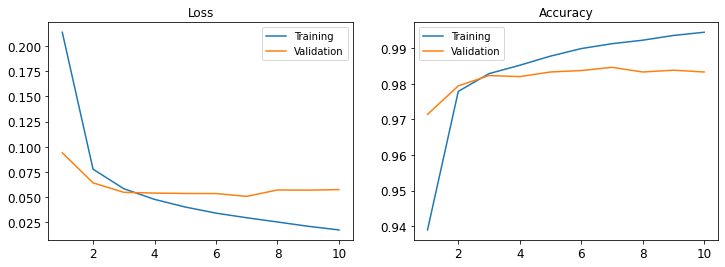

In [ ]:
def plot_loss_acc(history, epoch):

    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(range(1, epoch + 1), loss, label='Training')
    axes[0].plot(range(1, epoch + 1), val_loss, label='Validation')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')

    axes[1].plot(range(1, epoch + 1), acc, label='Training')
    axes[1].plot(range(1, epoch + 1), val_acc, label='Validation')
    axes[1].legend(loc='best')
    axes[1].set_title('Accuracy')

    plt.show()

plot_loss_acc(history, 10)

### 함수형 API 활용

#### 새로운 출력 생성 - 홀수:1, 짝수:0

In [ ]:
# 새로운 출력값 배열을 생성 (홀수: 1, 짝수: 0)
y_train_odd = []
for y in y_train:
    if y % 2==0:
        y_train_odd.append(0)
    else:
        y_train_odd.append(1)

y_train_odd = np.array(y_train_odd)
y_train_odd.shape

(60000,)

In [ ]:
print(y_train[:10])
print(y_train_odd[:10])

[5 0 4 1 9 2 1 3 1 4]
[1 0 0 1 1 0 1 1 1 0]


#### 검증 데이터 처리

In [ ]:
# Validation 데이터셋 처리
y_valid_odd = []
for y in y_valid:
    if y % 2==0:
        y_valid_odd.append(0)
    else:
        y_valid_odd.append(1)

y_valid_odd = np.array(y_valid_odd)
y_valid_odd.shape

(10000,)

#### 데이터 전처리

In [ ]:
# 정규화(Normalization)
x_train = x_train / 255.0
x_valid = x_valid / 255.0

# 채널 추가
x_train_in = tf.expand_dims(x_train, -1)
x_valid_in = tf.expand_dims(x_valid, -1)

print(x_train_in.shape, x_valid_in.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


#### Functional API 를 이용하여 다중 입력 및 다중 출력 모델 생성

In [ ]:
# Functional API를 사용하여 모델 생성

inputs = tf.keras.layers.Input(shape=(28, 28, 1))

conv = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)
flat = tf.keras.layers.Flatten()(pool)

flat_inputs = tf.keras.layers.Flatten()(inputs)
concat = tf.keras.layers.Concatenate()([flat, flat_inputs])
outputs = tf.keras.layers.Dense(10, activation='softmax')(concat)

model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 26, 26, 32)   320         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d_5 (MaxPooling2D)  (None, 13, 13, 32)  0           ['conv2d_6[0][0]']               
                                                                                                  
 flatten_3 (Flatten)            (None, 5408)         0           ['max_pooling2d_5[0][0]']        
                                                                                            

#### 모델 구조 출력 및 이미지 파일로 저장

In [ ]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file='functional_cnn.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


#### 모델 컴파일 및 훈련 과 평가

In [ ]:
# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
history = model.fit(x_train_in, y_train,
                    validation_data=(x_valid_in, y_valid),
                    epochs=10)

# 모델 성능
val_loss, val_acc = model.evaluate(x_valid_in, y_valid)
print(val_loss, val_acc)

Epoch 1/10
1875/1875 [==============================] - 9s 5ms/step - loss: 1.0904 - accuracy: 0.7417 - val_loss: 0.4712 - val_accuracy: 0.8715
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.4139 - accuracy: 0.8826 - val_loss: 0.3543 - val_accuracy: 0.9011
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3491 - accuracy: 0.8978 - val_loss: 0.3199 - val_accuracy: 0.9099
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3252 - accuracy: 0.9044 - val_loss: 0.3075 - val_accuracy: 0.9103
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3124 - accuracy: 0.9086 - val_loss: 0.2935 - val_accuracy: 0.9153
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3034 - accuracy: 0.9117 - val_loss: 0.2850 - val_accuracy: 0.9159
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2967 - accuracy: 0.9136 - val_loss: 0.2847 - val_accuracy:

#### Multi Output 모델

In [ ]:
# Functional API를 사용하여 모델 생성

inputs = tf.keras.layers.Input(shape=(28, 28, 1), name='inputs')

conv = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv2d_layer')(inputs)
pool = tf.keras.layers.MaxPooling2D((2, 2), name='maxpool_layer')(conv)
flat = tf.keras.layers.Flatten(name='flatten_layer')(pool)

flat_inputs = tf.keras.layers.Flatten()(inputs)
concat = tf.keras.layers.Concatenate()([flat, flat_inputs])
digit_outputs = tf.keras.layers.Dense(10, activation='softmax', name='digit_dense')(concat)

odd_outputs = tf.keras.layers.Dense(1, activation='sigmoid', name='odd_dense')(flat_inputs)

model = tf.keras.models.Model(inputs=inputs, outputs=[digit_outputs, odd_outputs])

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_layer (Conv2D)          (None, 26, 26, 32)   320         ['inputs[0][0]']                 
                                                                                                  
 maxpool_layer (MaxPooling2D)   (None, 13, 13, 32)   0           ['conv2d_layer[0][0]']           
                                                                                                  
 flatten_layer (Flatten)        (None, 5408)         0           ['maxpool_layer[0][0]']          
                                                                                            

#### 모델의 입력과 출력을 나타내는 텐서

In [ ]:
print(model.input)
print(model.output)

KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='inputs'), name='inputs', description="created by layer 'inputs'")
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'digit_dense')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'odd_dense')>]


#### 모델 구조 이미지 저장

In [ ]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file='multi_output_cnn.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


#### 모델 컴파일 및 훈련

In [ ]:
# 모델 컴파일
model.compile(optimizer='adam',
              loss={'digit_dense': 'sparse_categorical_crossentropy', 'odd_dense': 'binary_crossentropy'},
              loss_weights={'digit_dense': 1, 'odd_dense': 0.5}, # loss = 1.0 *sparse_categorical_crossentropy + 0.5*binary_crossentropy
              metrics=['accuracy'])

# 모델 훈련
history = model.fit({'inputs': x_train_in}, {'digit_dense': y_train, 'odd_dense': y_train_odd},
                    validation_data=({'inputs': x_valid_in},  {'digit_dense': y_valid, 'odd_dense': y_valid_odd}),
                    epochs=10)

Epoch 1/10
1875/1875 [==============================] - 10s 5ms/step - loss: 1.4944 - digit_dense_loss: 1.1595 - odd_dense_loss: 0.6698 - digit_dense_accuracy: 0.7298 - odd_dense_accuracy: 0.7575 - val_loss: 0.8287 - val_digit_dense_loss: 0.5057 - val_odd_dense_loss: 0.6460 - val_digit_dense_accuracy: 0.8647 - val_odd_dense_accuracy: 0.7976
Epoch 2/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.7485 - digit_dense_loss: 0.4347 - odd_dense_loss: 0.6276 - digit_dense_accuracy: 0.8784 - odd_dense_accuracy: 0.7976 - val_loss: 0.6712 - val_digit_dense_loss: 0.3681 - val_odd_dense_loss: 0.6061 - val_digit_dense_accuracy: 0.8969 - val_odd_dense_accuracy: 0.8009
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.6546 - digit_dense_loss: 0.3587 - odd_dense_loss: 0.5919 - digit_dense_accuracy: 0.8946 - odd_dense_accuracy: 0.8018 - val_loss: 0.6136 - val_digit_dense_loss: 0.3274 - val_odd_dense_loss: 0.5725 - val_digit_dense_accuracy: 0.9061 - val

#### 모델 평가

In [ ]:
model.evaluate({'inputs': x_valid_in}, {'digit_dense': y_valid, 'odd_dense': y_valid_odd})

313/313 [==============================] - 1s 2ms/step - loss: 0.4941 - digit_dense_loss: 0.2730 - odd_dense_loss: 0.4422 - digit_dense_accuracy: 0.9208 - odd_dense_accuracy: 0.8264


[0.49412861466407776,
 0.27302849292755127,
 0.4422003924846649,
 0.920799970626831,
 0.8263999819755554]

#### 샘플 이미지 출력

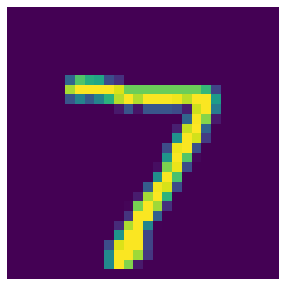

In [ ]:
import matplotlib.pylab as plt

def plot_image(data, idx):
    plt.figure(figsize=(5, 5))
    plt.imshow(data[idx])
    plt.axis("off")
    plt.show()

plot_image(x_valid, 0)

#### 모델 예측

In [ ]:
digit_preds, odd_preds = model.predict(x_valid_in)
print(digit_preds[0])
print(odd_preds[0])

[5.8864310e-07 3.4647570e-11 1.2470313e-06 1.9436277e-04 6.3521640e-08
 2.9406569e-06 6.2940715e-11 9.9958318e-01 2.6834869e-07 2.1726493e-04]
[0.82301235]


In [ ]:
digit_labels = np.argmax(digit_preds, axis=-1)
digit_labels[0:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 6, 9])

In [ ]:
odd_labels = (odd_preds > 0.5).astype(np.int).reshape(1, -1)[0]
odd_labels[0:10]

array([1, 0, 1, 0, 0, 1, 1, 1, 0, 1])

### 전이학습

#### 이전 모델을 이용해서 새로운 모델 생성

In [ ]:
# 앞의 모델에서 flatten_layer 출력을 추출
base_model_output = model.get_layer('flatten_layer').output

# 앞의 출력을 출력으로 하는 모델 정의
base_model = tf.keras.models.Model(inputs=model.input, outputs=base_model_output, name='base')
base_model.summary()

Model: "base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_layer (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 maxpool_layer (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten_layer (Flatten)     (None, 5408)              0         
                                                                 
Total params: 320
Trainable params: 320
Non-trainable params: 0
_________________________________________________________________


#### 모델 구조 저장

In [ ]:
keras.utils.plot_model(base_model, show_shapes=True, show_layer_names=True, to_file='base_model.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


#### 모델 생성

In [ ]:
# Sequential API 적용
digit_model = tf.keras.Sequential([
                                   base_model,
                                   tf.keras.layers.Dense(10, activation='softmax'),
                                   ])
digit_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base (Functional)           (None, 5408)              320       
                                                                 
 dense_6 (Dense)             (None, 10)                54090     
                                                                 
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________________


#### 모델 구조 저장

In [ ]:
keras.utils.plot_model(digit_model, show_shapes=True, show_layer_names=True, to_file='digit_model.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


#### 모델 컴파일 및 훈련

In [ ]:
# 모델 컴파일
digit_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
history = digit_model.fit(x_train_in, y_train,
                    validation_data=(x_valid_in, y_valid),
                    epochs=10)

Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.7026 - accuracy: 0.8370 - val_loss: 0.3847 - val_accuracy: 0.8937
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3595 - accuracy: 0.8971 - val_loss: 0.3174 - val_accuracy: 0.9095
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3200 - accuracy: 0.9067 - val_loss: 0.2967 - val_accuracy: 0.9145
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3032 - accuracy: 0.9114 - val_loss: 0.2899 - val_accuracy: 0.9149
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2939 - accuracy: 0.9139 - val_loss: 0.2777 - val_accuracy: 0.9196
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2868 - accuracy: 0.9164 - val_loss: 0.2699 - val_accuracy: 0.9215
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2815 - accuracy: 0.9187 - val_loss: 0.2738 - val_accuracy:

#### 베이스 모델의 가중치를 고정 (Freeze Model)

In [ ]:
base_model_frozen = tf.keras.models.Model(inputs=model.input, outputs=base_model_output, name='base_frozen')
base_model_frozen.trainable = False
base_model_frozen.summary()

Model: "base_frozen"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_layer (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 maxpool_layer (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten_layer (Flatten)     (None, 5408)              0         
                                                                 
Total params: 320
Trainable params: 0
Non-trainable params: 320
_________________________________________________________________


#### 함수형 API 적용

In [ ]:
dense_output = tf.keras.layers.Dense(10, activation='softmax')(base_model_frozen.output)
digit_model_frozen = tf.keras.models.Model(inputs=base_model_frozen.input, outputs=dense_output)
digit_model_frozen.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_layer (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 maxpool_layer (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten_layer (Flatten)     (None, 5408)              0         
                                                                 
 dense_7 (Dense)             (None, 10)                54090     
                                                                 
Total params: 54,410
Trainable params: 54,090
Non-trainable params: 320
_____________________________________________________

#### 모델 컴파일 및 훈련

In [ ]:
# 모델 컴파일
digit_model_frozen.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
history = digit_model_frozen.fit(x_train_in, y_train,
                    validation_data=(x_valid_in, y_valid),
                    epochs=10)

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5878 - accuracy: 0.8570 - val_loss: 0.3568 - val_accuracy: 0.9020
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3438 - accuracy: 0.9017 - val_loss: 0.3096 - val_accuracy: 0.9128
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3134 - accuracy: 0.9091 - val_loss: 0.2911 - val_accuracy: 0.9150
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2989 - accuracy: 0.9130 - val_loss: 0.2854 - val_accuracy: 0.9173
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2907 - accuracy: 0.9153 - val_loss: 0.2758 - val_accuracy: 0.9212
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2840 - accuracy: 0.9176 - val_loss: 0.2679 - val_accuracy: 0.9226
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2791 - accuracy: 0.9190 - val_loss: 0.2720 - val_accuracy:

#### 베이스 모델의 Conv2D 레이어의 가중치만 고정 (Freeze Layer)

In [ ]:
base_model_frozen2 = tf.keras.models.Model(inputs=model.input, outputs=base_model_output, name='base_frozen2')
base_model_frozen2.get_layer('conv2d_layer').trainable = False
base_model_frozen2.summary()

Model: "base_frozen2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_layer (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 maxpool_layer (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten_layer (Flatten)     (None, 5408)              0         
                                                                 
Total params: 320
Trainable params: 0
Non-trainable params: 320
_________________________________________________________________


#### 함수형 API 적용

In [ ]:
dense_output2 = tf.keras.layers.Dense(10, activation='softmax')(base_model_frozen2.output)
digit_model_frozen2 = tf.keras.models.Model(inputs=base_model_frozen2.input, outputs=dense_output2)
digit_model_frozen2.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_layer (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 maxpool_layer (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten_layer (Flatten)     (None, 5408)              0         
                                                                 
 dense_8 (Dense)             (None, 10)                54090     
                                                                 
Total params: 54,410
Trainable params: 54,090
Non-trainable params: 320
_____________________________________________________

#### 모델 컴파일 및 훈련

In [ ]:
# 모델 컴파일
digit_model_frozen2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
history = digit_model_frozen2.fit(x_train_in, y_train,
                    validation_data=(x_valid_in, y_valid),
                    epochs=10)

Epoch 1/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.5872 - accuracy: 0.8573 - val_loss: 0.3568 - val_accuracy: 0.9019
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3438 - accuracy: 0.9019 - val_loss: 0.3096 - val_accuracy: 0.9123
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3134 - accuracy: 0.9091 - val_loss: 0.2912 - val_accuracy: 0.9150
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2989 - accuracy: 0.9130 - val_loss: 0.2855 - val_accuracy: 0.9172
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2907 - accuracy: 0.9152 - val_loss: 0.2759 - val_accuracy: 0.9208
Epoch 6/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2840 - accuracy: 0.9177 - val_loss: 0.2680 - val_accuracy: 0.9229
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2791 - accuracy: 0.9190 - val_loss: 0.2721 - val_accuracy:

## 데이터 증강

In [ ]:
#이미지 다운로드
!git clone https://github.com/MachineLearning2020/Homework2-Caltech101.git

Cloning into 'Homework2-Caltech101'...
remote: Enumerating objects: 9256, done.
remote: Total 9256 (delta 0), reused 0 (delta 0), pack-reused 9256
Receiving objects: 100% (9256/9256), 129.48 MiB | 22.87 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Updating files: 100% (9149/9149), done.


In [ ]:
import glob
from sklearn.model_selection import train_test_split
# 분류 대상 카테고리 선택하기 --- (※1)
caltech_dir = "Homework2-Caltech101/101_ObjectCategories"
categories = ["chair","camera","butterfly","elephant","flamingo"]
nb_classes = len(categories)
# 이미지 크기 지정 --- (※2)
image_w = 64
image_h = 64
pixels = image_w * image_h * 3


In [ ]:
from PIL import Image
# 이미지를 저장하기 위한 list
X = []
# 타겟을 저장하기 위한 list
Y = []

# list를 순회할 때 index와 value를 같이 가져오고자 하는 경우 enumerate 사용
for idx, cat in enumerate(categories):
  # 레이블 지정 --- (※4)

  label = [0 for i in range(nb_classes)]
  #원핫 인코딩을 위해서 클래스 개수 만큼의 list를 생성
  label[idx] = 1

  # 이미지 --- (※5)
  # 카테고리에 해당하는 디렉토리 경로를 생성
  image_dir = caltech_dir + "/" + cat
  #디렉토리에서 확장자가 jpg인 모든 파일의 경로를 문다열 list로 생성
  files = glob.glob(image_dir+"/*.jpg")

  #이미지 읽기
  for i, f in enumerate(files):
    #이미지 파일의 내용 읽기
    img = Image.open(f) # --- (※6)
    #이미지의 채널을 설정 - rgb로 변경
    img = img.convert("RGB")
    #이미지 리사이징 - 합성곱에 넣을 때는 이미지를 동일한 크기로 만들어 주어야 함
    img = img.resize((image_w, image_h))
    #numpy 배열로 생성
    data = np.asarray(img)
    #리스트에 이미지와 레이블을 추가
    X.append(data)
    Y.append(label)
    if i % 10 == 0:
      print(i, "\n", data)
X = np.array(X)
Y = np.array(Y)

0 
 [[[159 159 159]
  [196 196 196]
  [195 195 195]
  ...
  [195 195 195]
  [197 197 197]
  [123 123 123]]

 [[214 214 214]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [160 160 160]]

 [[212 212 212]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [159 159 159]]

 ...

 [[211 211 211]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [159 159 159]]

 [[216 216 216]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [162 162 162]]

 [[102 102 102]
  [121 121 121]
  [121 121 121]
  ...
  [122 122 122]
  [122 122 122]
  [ 75  75  75]]]
10 
 [[[175 154 100]
  [224 201 160]
  [238 213 185]
  ...
  [182 160 134]
  [182 160 134]
  [179 157 131]]

 [[176 155 100]
  [226 203 161]
  [238 213 185]
  ...
  [149 125  90]
  [146 122  87]
  [144 119  85]]

 [[175 154 100]
  [226 203 162]
  [239 213 186]
  ...
  [136 106  71]
  [133 104  68]
  [133 104  68]]

 ...

 [[127 106  84]
  [120  85  69]
  [153 104 

In [ ]:
# 학습 전용 데이터와 테스트 전용 데이터 구분 – 디렉토리가 없으면 data/image 생성

# 훈련 데이터와 테스트 데잉터를 분할한 후 튜플로 생성
X_train, X_test, y_train, y_test = \
  train_test_split(X, Y)
xy = (X_train, X_test, y_train, y_test)

# 데이터를 다시 사용하고자 하는 경우 numpy 배열로 저장해두면 나중에 읽어올 때 편리
# 포트폴리오나 프로젝트를 진행하다 보면 데이터를 여러 번 호출해야 하는 경우가 발생
# 이런 경우에는 numpy 파일로 저장해두고 읽으면 편리
np.save("./data/image/5obj.npy", xy)
print("ok,", len(Y))

ok, 334


In [ ]:
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
import numpy as np
# 카테고리 지정하기
categories = ["chair","camera","butterfly","elephant","flamingo"]
nb_classes = len(categories)

# 이미지 크기 지정하기
image_w = 64
image_h = 64

# 데이터 불러오기 --- (※1)
# pickle - Serializable을 pickle 가지고 수행
# Serializable(직렬화) - 객체 단위로 데이터를 전
X_train, X_test, y_train, y_test = np.load("./data/image/5obj.npy", allow_pickle=True)

# 데이터 정규화하기
X_train = X_train.astype("float") / 256
X_test = X_test.astype("float") / 256
print('X_train shape:', X_train.shape)

X_train shape: (250, 64, 64, 3)


In [ ]:
# 모델 구축하기 --- (※2)
model = Sequential()

print(X_train.shape[1:])

#입력 층을 합성 곱으로 생성
#커널의 개수는 32개 커널의 크기는 3*3, 제로 패딩 사용
#입력 층은 입력되는 데이터의 shape을 설정 - 데이터 개수는 제외
model.add(Convolution2D(32, kernel_size=3, padding='same',input_shape=(64,64,3)))
#활성화 함수 설정
model.add(Activation('relu'))
#2*2
#특성 맥의 크기가 줄어듬
model.add(MaxPooling2D(2))
#뉴런은 25%를 제거
model.add(Dropout(0.25))

#합성곱 층
model.add(Convolution2D(64, kernel_size=3, padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3))

model.add(MaxPooling2D(2))
model.add(Dropout(0.25))

#완전 연결층 - 입력의 크기를 1차원으로
model.add(Flatten()) # --- (※3)
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

#출력 층 생성 -뉴런의 개수가 1 또는 클래스 개
model.add(Dense(nb_classes))
model.add(Activation('softmax'))


(64, 64, 3)


In [ ]:
model.compile(loss='binary_crossentropy',optimizer='rmsprop', metrics=['accuracy'])
# 모델 훈련하기 --- (※4)
hdf5_file = "./data/image/5obj-model.hdf5"
if os.path.exists(hdf5_file):
  model.load_weights(hdf5_file)
else:
  model.fit(X_train, y_train, batch_size=32, epochs=50)
  model.save_weights(hdf5_file)

# 모델 평가하기--- (※5)
score = model.evaluate(X_test, y_test)
print('loss=', score[0])
print('accuracy=', score[1])


Epoch 1/50
8/8 [==============================] - 4s 154ms/step - loss: 0.5624 - accuracy: 0.2680
Epoch 2/50
8/8 [==============================] - 1s 139ms/step - loss: 0.5110 - accuracy: 0.2680
Epoch 3/50
8/8 [==============================] - 1s 134ms/step - loss: 0.5037 - accuracy: 0.3120
Epoch 4/50
8/8 [==============================] - 1s 140ms/step - loss: 0.4895 - accuracy: 0.3240
Epoch 5/50
8/8 [==============================] - 1s 127ms/step - loss: 0.4736 - accuracy: 0.3440
Epoch 6/50
8/8 [==============================] - 1s 132ms/step - loss: 0.4440 - accuracy: 0.4000
Epoch 7/50
8/8 [==============================] - 1s 129ms/step - loss: 0.4198 - accuracy: 0.4520
Epoch 8/50
8/8 [==============================] - 1s 134ms/step - loss: 0.3942 - accuracy: 0.5040
Epoch 9/50
8/8 [==============================] - 1s 152ms/step - loss: 0.3606 - accuracy: 0.6000
Epoch 10/50
8/8 [==============================] - 2s 188ms/step - loss: 0.3652 - accuracy: 0.5720
Epoch 11/50
8/8 [==

In [ ]:
img = Image.open('/content/drive/MyDrive/DX school/0916_Data/chair.png')
img = img.convert("RGB")
img = img.resize((image_w, image_h))
data = np.asarray(img)
data = data.astype("float") / 256
data = data.reshape(-1, 64, 64, 3)
score = model.predict(data)
print(score)
for category, prob in enumerate(zip(categories, score[0])):
  print(category, prob)

1/1 [==============================] - 0s 78ms/step
[[1.0000000e+00 3.7336556e-09 6.1724137e-10 6.7073696e-13 2.9357786e-08]]
0 ('chair', 1.0)
1 ('camera', 3.7336556e-09)
2 ('butterfly', 6.1724137e-10)
3 ('elephant', 6.7073696e-13)
4 ('flamingo', 2.9357786e-08)


In [ ]:
# 모델 평가하기
pre = model.predict(X_test)
for i,v in enumerate(pre):
  pre_ans = v.argmax()
  ans = y_test[i].argmax()
  dat = X_test[i]
  if ans == pre_ans: continue
  print("[NG]", categories[pre_ans], "!=", categories[ans])
  print(v)
  #오류 파일에서 오류가 자주 나는 것을 보고 그 사진의 데이터를 더 넣어주거나
  fname = "./data/image/error/" + str(i) + "-" + categories[pre_ans] + \
  "-ne-" + categories[ans] + ".png"
  dat *= 256
  img = Image.fromarray(np.uint8(dat))
  img.save(fname)

3/3 [==============================] - 0s 31ms/step
[NG] chair != flamingo
[6.3703227e-01 1.2372513e-09 3.0730751e-01 2.7166817e-11 5.5660285e-02]
[NG] chair != flamingo
[5.3129345e-01 1.0769320e-06 3.8614941e-01 6.5622896e-02 1.6933190e-02]
[NG] elephant != flamingo
[4.0761456e-08 1.6546914e-05 3.7911260e-01 6.2010264e-01 7.6816964e-04]
[NG] chair != elephant
[9.8952931e-01 5.9882306e-05 1.6904948e-03 8.4821824e-03 2.3809444e-04]
[NG] elephant != chair
[3.5954718e-02 1.4764613e-07 9.1709464e-04 9.6259946e-01 5.2868592e-04]
[NG] butterfly != chair
[8.6902216e-02 1.5959473e-06 9.1283470e-01 6.2466497e-05 1.9903090e-04]
[NG] butterfly != flamingo
[5.2155588e-06 2.5435445e-05 9.9704868e-01 2.5144281e-04 2.6692662e-03]
[NG] butterfly != chair
[3.0038616e-02 5.8283613e-09 9.6996129e-01 1.2500955e-08 1.0224821e-08]
[NG] butterfly != elephant
[1.1022758e-09 4.7828581e-12 9.9999994e-01 2.8199680e-12 4.8579885e-13]
[NG] chair != camera
[9.7937703e-01 7.3388668e-07 5.7222955e-03 1.4900001e-02 2.

### augmentor

In [ ]:
! pip install augmentor

In [ ]:
import Augmentor

#증강 시킬 이미지 폴더 경로
img = Augmentor.Pipeline("./data/sample")

# 좌우 반전
img.flip_left_right(probability=1.0)

# 상하 반전
img.flip_top_bottom(probability=1.0)

#모퉁이 왜곡
img.skew_corner(probability=1.0)

#회전&크롭
img.rotate_without_crop(probability=1, max_left_rotation=0.8, max_right_rotation=0.8, expand=False, fillcolor=None)

# 왜곡
img.random_distortion(probability=1, grid_width=10, grid_height=10, magnitude=30)

#확대
img.zoom_random(probability=1, percentage_area=0.8)

#크롭
img.crop_random(probability=1, percentage_area=0.8, randomise_percentage_area=False)

#랜덤 지우기
img.random_erasing(probability=1.0, rectangle_area=0.3)

# 증강 이미지 수
img.sample(1)

Initialised with 1 image(s) found.
Output directory set to ./data/sample/output.

Processing <PIL.Image.Image image mode=RGB size=216x149 at 0x79F060564970>: 100%|██████████| 1/1 [00:00<00:00, 13.36 Samples/s]


### ImageDataGenerator

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

#옵션을 이용해서 이미지 증강을
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

#어떤 그림을 증강할지 선택
img = load_img('/content/drive/MyDrive/DX school/0916_Data/windsor_castle.jpg')  # PIL 이미지
x = img_to_array(img)  # (3, 150, 150) 크기의 NumPy 배열
#이미지 1개는 2D 텐서나 3D 텐서
#케라스는 기본적으로 4D 텐서를 다룸
print(x.shape)

x = x.reshape((1,) + x.shape)  # (1, 3, 150, 150) 크기의 NumPy 배열

# 아래 .flow() 함수는 임의 변환된 이미지를 배치 단위로 생성해서
# 지정된 `preview/` 폴더에 저장합니다.
# 파일의 이름 앞에는 adam을 추가하고 포맷은 jpeg
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='./data/sample', save_prefix='adam', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # 이미지 20장을 생성하고 마칩니다
print(x.shape)

(75, 100, 3)
(1, 75, 100, 3)


### 개/고양이 분류

#### 데이터 가져오기

In [ ]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2023-09-19 08:08:09--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.63.207, 142.251.111.207, 142.251.16.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.63.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   179MB/s    in 0.4s    

2023-09-19 08:08:09 (179 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
# 압출 풀기 - zip과 tar로 가능
import shutil
shutil.unpack_archive('cats_and_dogs_filtered.zip', './data/dataset/')

In [ ]:
train_dir = "/content/data/dataset/cats_and_dogs_filtered/train"
valid_dir = "/content/data/dataset/cats_and_dogs_filtered/validation"
print(train_dir)
print(valid_dir)

/content/data/dataset/cats_and_dogs_filtered/train
/content/data/dataset/cats_and_dogs_filtered/validation


#### 이미지 데이터 제너레이터 - 이미지 증강

In [ ]:
image_gen = ImageDataGenerator(rescale=(1/255.))
image_gen

In [ ]:
train_gen = image_gen.flow_from_directory(train_dir,
                                          batch_size=32,
                                          target_size=(224, 224),
                                          classes=['cats','dogs'],
                                          class_mode = 'binary',
                                          seed=2020)

valid_gen = image_gen.flow_from_directory(valid_dir,
                                          batch_size=32,
                                          target_size=(224, 224),
                                          classes=['cats','dogs'],
                                          class_mode = 'binary',
                                          seed=2020)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#### 샘플 이미지 출력

In [ ]:
class_labels = ['cats', 'dogs']
batch = next(train_gen)
images, labels = batch[0], batch[1]

plt.figure(figsize=(16, 8))
for i in range(32):

    ax = plt.subplot(4, 8, i + 1)
    plt.imshow(images[i])
    plt.title(class_labels[labels[i].astype(np.int)])
    plt.axis("off")
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

#### 모델 생성

In [ ]:
def build_model():
    model = tf.keras.Sequential([
        # Convolution 층
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        # Classifier 출력층
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])
    return model

In [ ]:
model = build_model()

#### 모델 컴파일 및 훈련 - 느림

In [ ]:
# 모델 컴파일
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 모델 훈련
history = model.fit(train_gen, validation_data=valid_gen, epochs=20)

Epoch 1/20
63/63 [==============================] - 223s 4s/step - loss: 3.3488 - accuracy: 0.5655 - val_loss: 0.6880 - val_accuracy: 0.5170
Epoch 2/20
63/63 [==============================] - ETA: 0s - loss: 0.6370 - accuracy: 0.6385

KeyboardInterrupt: ignored

#### 손실 및 정확도 그래프

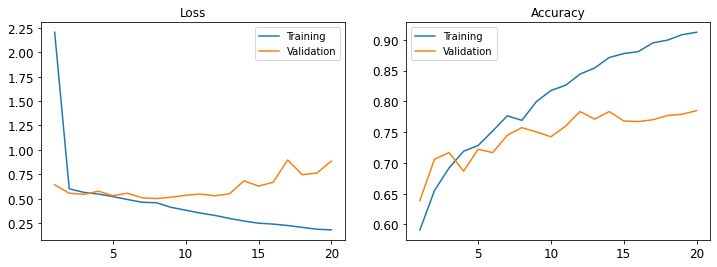

In [ ]:
def plot_loss_acc(history, epoch):

    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(range(1, epoch + 1), loss, label='Training')
    axes[0].plot(range(1, epoch + 1), val_loss, label='Validation')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')

    axes[1].plot(range(1, epoch + 1), acc, label='Training')
    axes[1].plot(range(1, epoch + 1), val_acc, label='Validation')
    axes[1].legend(loc='best')
    axes[1].set_title('Accuracy')

    plt.show()


plot_loss_acc(history, 20)

#### 이미지 증강 후 모델 생성 및 훈련

In [ ]:
# 이미지 데이터 제너레이터 정의 (Augmentation 적용)
image_gen_aug = ImageDataGenerator(rescale=1/255.,
                                   horizontal_flip=True,
                                   rotation_range=35,
                                   zoom_range=0.2)

# flow_from_directory 함수로 폴더에서 이미지 가져와서 제너레이터 객체로 정리
train_gen_aug = image_gen_aug.flow_from_directory(train_dir,
                                                  batch_size=32,
                                                  target_size=(224,224),
                                                  classes=['cats','dogs'],
                                                  class_mode = 'binary',
                                                  seed=2020)

valid_gen_aug = image_gen_aug.flow_from_directory(valid_dir,
                                                  batch_size=32,
                                                  target_size=(224,224),
                                                  classes=['cats','dogs'],
                                                  class_mode = 'binary',
                                                  seed=2020)


Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


In [ ]:
# 오래 걸림

# 모델 생성
model_aug = build_model()

# 모델 컴파일
model_aug.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 모델 훈련
history_aug = model_aug.fit(train_gen_aug, validation_data=valid_gen_aug, epochs=40)

Epoch 1/40
251/251 [==============================] - 601s 2s/step - loss: 2.5072 - accuracy: 0.6016 - val_loss: 0.6205 - val_accuracy: 0.6787
Epoch 2/40
251/251 [==============================] - 449s 2s/step - loss: 0.6101 - accuracy: 0.6628 - val_loss: 0.6262 - val_accuracy: 0.6293
Epoch 3/40
251/251 [==============================] - 1183s 5s/step - loss: 0.5900 - accuracy: 0.6793 - val_loss: 0.5735 - val_accuracy: 0.7118
Epoch 4/40
251/251 [==============================] - 456s 2s/step - loss: 0.5818 - accuracy: 0.6913 - val_loss: 0.5666 - val_accuracy: 0.7153
Epoch 5/40
251/251 [==============================] - 449s 2s/step - loss: 0.5702 - accuracy: 0.6959 - val_loss: 0.5420 - val_accuracy: 0.7182
Epoch 6/40
251/251 [==============================] - 454s 2s/step - loss: 0.5579 - accuracy: 0.7046 - val_loss: 0.5877 - val_accuracy: 0.6797
Epoch 7/40
251/251 [==============================] - 1401s 6s/step - loss: 0.5429 - accuracy: 0.7245 - val_loss: 0.5124 - val_accuracy: 0.73

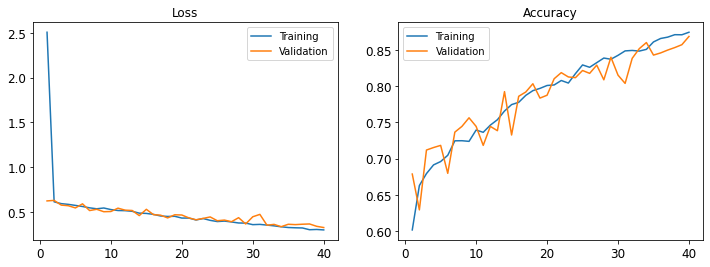

In [ ]:
#이미지 개수가 적을 때는 증강을 하면 확률이 많이 좋아지는데
#이미지 개수가 많을 때는 증강을 해도 정확도가 많이 좋아지지 않음
#앞에서 조기 종료가 되면 조기 종료된 epoch 값을 설정해야 함
plot_loss_acc(history_aug, 40)

## 이미지 분류 전이 학습

### LeNet-5

#### 데이터 가져오기

In [5]:
num_classes = 10
img_rows, img_cols, img_ch = 28, 28, 1
input_shape = (img_rows, img_cols, img_ch)

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = x_train.reshape(x_train.shape[0], *input_shape)
x_test = x_test.reshape(x_test.shape[0], *input_shape)

11490434/11490434 [==============================] - 0s 0us/step


#### 모델 클래스

In [7]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

class LeNet5(Model):

    def __init__(self, num_classes):
        """
        Initialize the model.
        :param num_classes:     Number of classes to predict from
        """
        # super()안에 class 이름 작성하면 다중 상
        super(LeNet5, self).__init__()
        # We instantiate the various layers composing LeNet-5:
        # self.conv1 = SimpleConvolutionLayer(6, kernel_size=(5, 5))
        # self.conv2 = SimpleConvolutionLayer(16, kernel_size=(5, 5))
        # ... or using the existing and (recommended) Conv2D class:

        # 합성곱 층을 생성 - 6은 커널(필터)의 개수, kernal_size는 연산을 수행할 단위
        # padding이 0 추가 여부 actvation 함수는 활성화 함수로 relu
        self.conv1 = Conv2D(6, kernel_size=(5, 5), padding='same', activation='relu')
        self.conv2 = Conv2D(16, kernel_size=(5, 5), activation='relu')
        # 최대 풀링 층 - 2라고 설정해도 됨
        self.max_pool = MaxPooling2D(pool_size=(2, 2))
        # 1차원으로 만들어주는 층
        self.flatten = Flatten()
        self.dense1 = Dense(120, activation='relu')
        self.dense2 = Dense(84, activation='relu')
        # 출력 층
        self.dense3 = Dense(num_classes, activation='softmax')

    # 모델을 구성하는 함수
    def call(self, inputs):
        """
        Call the layers and perform their operations on the input tensors
        :param inputs:  Input tensor
        :return:        Output tensor
        """
        # 합성곱을 첫번째 입력으로 해서 풀링 층 생성
        x = self.max_pool(self.conv1(inputs))        # 1st block
        #다른 합성곱을 입력해서 풀링 층을 생성
        x = self.max_pool(self.conv2(x))             # 2nd block
        # 1차원으로 변
        x = self.flatten(x)
        x = self.dense3(self.dense2(self.dense1(x))) # dense layers
        return x


#사용자 정의 모델을 만드는 방법
  #Model 클래스로부터 상속을 받고 init 메서드를 재정의해서 레이어를 생성
  #call 메서드를 재정의해서 레이어를 순서대로 배치하면 됨

#### 모델 컴파일

In [9]:
#모델 생성 및 컴파일
#르쿤이 만들 때는 다양한 Opimizer 가 없어서 경사 하강법을 사용
model = LeNet5(num_classes)
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#### 예측

In [10]:
_ = model.predict(x_test[:10])

1/1 [==============================] - 1s 1s/step


#### 모델 구조

In [11]:
batched_input_shape = tf.TensorShape((None, *input_shape))
model.build(input_shape=batched_input_shape)
model.summary()

Model: "le_net5_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           multiple                  156       
                                                                 
 conv2d_3 (Conv2D)           multiple                  2416      
                                                                 
 max_pooling2d_1 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         multiple                  0         
                                                                 
 dense_3 (Dense)             multiple                  48120     
                                                                 
 dense_4 (Dense)             multiple                  10164     
                                                         

#### 콜백 생성

In [17]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
    #TensorBoard = 로그 기록 // 로그 기록은 무조건 해야됨
    tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True)]

#### 콜백 적용 후 훈련

In [13]:
history = model.fit(x_train, y_train,
                    batch_size=32, epochs=80, validation_data=(x_test, y_test),
                    verbose=2,  # change to `verbose=1` to get a progress bar
                                # (we opt for `verbose=2` here to reduce the log size)
                    callbacks=callbacks)

Epoch 1/80
1875/1875 - 67s - loss: 0.5373 - accuracy: 0.8436 - val_loss: 0.1394 - val_accuracy: 0.9549 - 67s/epoch - 36ms/step
Epoch 2/80
1875/1875 - 59s - loss: 0.1272 - accuracy: 0.9613 - val_loss: 0.1051 - val_accuracy: 0.9681 - 59s/epoch - 32ms/step
Epoch 3/80
1875/1875 - 49s - loss: 0.0911 - accuracy: 0.9716 - val_loss: 0.0662 - val_accuracy: 0.9807 - 49s/epoch - 26ms/step
Epoch 4/80
1875/1875 - 52s - loss: 0.0744 - accuracy: 0.9772 - val_loss: 0.0747 - val_accuracy: 0.9768 - 52s/epoch - 28ms/step
Epoch 5/80
1875/1875 - 49s - loss: 0.0643 - accuracy: 0.9799 - val_loss: 0.0643 - val_accuracy: 0.9785 - 49s/epoch - 26ms/step
Epoch 6/80
1875/1875 - 52s - loss: 0.0564 - accuracy: 0.9823 - val_loss: 0.0482 - val_accuracy: 0.9848 - 52s/epoch - 28ms/step
Epoch 7/80
1875/1875 - 50s - loss: 0.0505 - accuracy: 0.9844 - val_loss: 0.0499 - val_accuracy: 0.9828 - 50s/epoch - 27ms/step
Epoch 8/80
1875/1875 - 48s - loss: 0.0456 - accuracy: 0.9853 - val_loss: 0.0511 - val_accuracy: 0.9836 - 48s/ep

### VGG

#### VGG 사전 학습 가중치를 이용한 이미지 분류

In [18]:
'''
ref1:
https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5
ref2: # https://keras.io/applications/
'''
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.applications.imagenet_utils  import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image # pip install pillow

#VGG16이 학습한 내용을 그대로 사용하는 모델을 생성
model = VGG16(weights='imagenet', include_top=True) # weights= W
model.summary()

#판정할 이미지를 생성
img_path = '/content/drive/MyDrive/DX school/0916_Data/elephant.jpg'
#VGG는 224 * 224 이미지를 이용해서 학습
img = image.load_img(img_path, target_size=(224, 224))
#이미지를 numpy 배열로 읽어오기
x = image.img_to_array(img)
#차원을 추가해서 4차원 텐서를 생성 - 각각의 이미지는 3차원 텐서
x = np.expand_dims(x, axis=0)  # (1, 224, 224, 3)
x = preprocess_input(x) # mode='caffe'
output = model.predict(x)

print('Predicted:', decode_predictions(output, top=5)[0])

k = np.argmax(output[0])            # top 1
z = output[0].argsort()[-5:][::-1]    # top 5

labels = {}
#이미지 넷의 인덱스에 해당하는 실제 클래스 이름을 가진 텍스트 파일
name = "./data/imagenet1000_clsidx_to_labels.txt"
with open(name, 'r') as f:
    C = [line[:-2] for line in f.readlines()]
C[0] = C[0][1:]
for line in C:
    line = line.replace("'", "")
    key, value = line.split(':')
    labels[int(key)] = value.strip()
print('Top-1 prediction:', labels[k])
print('Top-5 prediction:', [labels[i] for i in z])

plt.imshow(img)
plt.title(labels[k])
plt.axis("off")
plt.show()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

FileNotFoundError: ignored

#### VGG16 구조를 이용한 이미지 분류 - 많이 느림

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

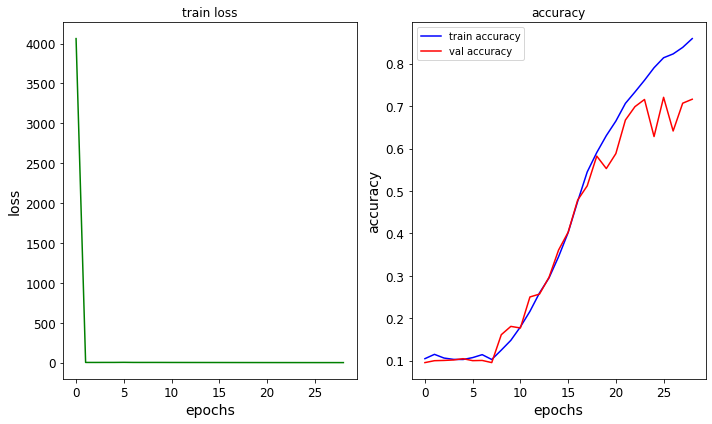

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16
import numpy as np
import matplotlib.pyplot as plt

#기존 모델이 학습하지 않은 데이터를 추가해서 학습 - 클래스가 10개

#데이터 가져오기
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') # (50000, 32, 32, 3)
x_test  = x_test.astype('float32')  # (10000, 32, 32, 3)

#타겟을 카테고리로 생성
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

x_train= preprocess_input(x_train)
x_test = preprocess_input(x_test)

#기존의 모델의 가중치만 이용해서 새로 학습해서 모델을 생성
#층의 구조 등은 그대로 사용
#분류할 종류가 10가지라서 클래스


model = VGG16(weights=None, include_top=True, classes=10, input_shape=(32,32,3))
model.summary()

#옵티마이저 수정
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
#컴파일
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
#훈련
ret = model.fit(x_train, y_train, epochs=100, batch_size=400,
                validation_split=0.2, verbose=1, callbacks = callbacks)
#평가
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=2)
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].plot(ret.history['loss'],  "g-")
ax[0].set_title("train loss")
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')

ax[1].plot(ret.history['accuracy'],     "b-", label="train accuracy")
ax[1].plot(ret.history['val_accuracy'], "r-", label="val accuracy")
ax[1].set_title("accuracy")
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('accuracy')
plt.legend(loc="best")
fig.tight_layout()
plt.show()

### Inception V3 를 이용한 CIFAR-10 분류

#### 라이브러리 import

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers   import Input, Conv2D, Dense
from tensorflow.keras.layers   import Flatten, MaxPooling2D, GlobalAveragePooling2D
import numpy as np
import matplotlib.pyplot as plt

#### 데이터 가져오기

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#### 데이터 전처리

In [ ]:
x_train = x_train.astype('float32') # (50000, 32, 32, 3)
x_test  = x_test.astype('float32')  # (10000, 32, 32, 3)

x_train = x_train / 255.0
x_test  = x_test / 255.0

# one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train)
y_test  = tf.keras.utils.to_categorical(y_test)

#### 간단한 Inception_Layer 구현

In [ ]:
#inception은 데이터의 방향이 한 곳으로만 흐르지 않고 여러 곳으로 흐르도록 해서
#연산 속도도 높이고 여러 개의 출력을 만들어서 예측 성능도 높이는 방
inputs = Input(shape=(32, 32, 3))

#커널의 크기가 다름
L1 = Conv2D(64, (1,1), padding='same', activation='relu', name="L1")(inputs)
L2 = Conv2D(64, (3,3), padding='same', activation='relu', name="L2")(L1)

L3 = Conv2D(64, (1,1), padding='same', activation='relu')(inputs)
L3 = Conv2D(64, (5,5), padding='same', activation='relu', name="L3")(L3)

L4 = MaxPooling2D((3,3), strides=(1,1), padding='same')(inputs)
L4 = Conv2D(64, (1,1), padding='same', activation='relu', name="L4")(L4)
# 동시에 4가지 방법으로 학습
output = tf.keras.layers.concatenate([L1, L2, L3, L4], axis = 3)

output = Flatten()(output)
outs   = Dense(10, activation='softmax')(output)

#### 모델 생성 및 구조 확인

In [ ]:
model  = tf.keras.Model(inputs=inputs, outputs=outs)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 L1 (Conv2D)                    (None, 32, 32, 64)   256         ['input_4[0][0]']                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 32, 32, 64)   256         ['input_4[0][0]']                
                                                                                                  
 max_pooling2d_13 (MaxPooling2D  (None, 32, 32, 3)   0           ['input_4[0][0]']                
 )                                                                                          

#### 훈련 및 평가

Epoch 1/30
313/313 [==============================] - 237s 755ms/step - loss: 2.8139 - accuracy: 0.3767 - val_loss: 1.4997 - val_accuracy: 0.4600
Epoch 2/30
313/313 [==============================] - 477s 2s/step - loss: 1.2250 - accuracy: 0.5748 - val_loss: 1.2294 - val_accuracy: 0.5798
Epoch 3/30
313/313 [==============================] - 249s 796ms/step - loss: 1.0213 - accuracy: 0.6488 - val_loss: 1.2437 - val_accuracy: 0.5786
Epoch 4/30
313/313 [==============================] - 237s 758ms/step - loss: 0.8787 - accuracy: 0.6996 - val_loss: 1.2218 - val_accuracy: 0.6001
Epoch 5/30
313/313 [==============================] - 239s 764ms/step - loss: 0.7457 - accuracy: 0.7441 - val_loss: 1.2876 - val_accuracy: 0.5966
Epoch 6/30
313/313 [==============================] - 13655s 44s/step - loss: 0.6332 - accuracy: 0.7849 - val_loss: 1.2195 - val_accuracy: 0.6251
Epoch 7/30
313/313 [==============================] - 279s 891ms/step - loss: 0.5303 - accuracy: 0.8215 - val_loss: 1.4328 - va

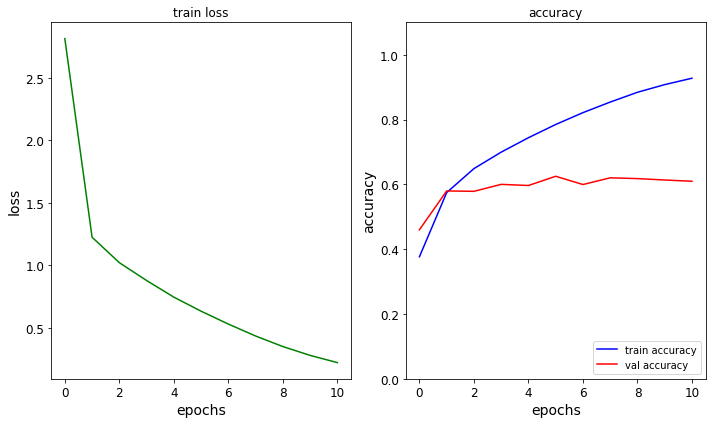

In [ ]:
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
ret = model.fit(x_train, y_train, epochs=30, batch_size=128,
                validation_split=0.2, verbose=1, callbacks = callbacks)

train_loss, train_acc = model.evaluate(x_train, y_train, verbose=2)
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].plot(ret.history['loss'],  "g-")
ax[0].set_title("train loss")
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')

ax[1].set_ylim(0, 1.1)
ax[1].plot(ret.history['accuracy'],     "b-", label="train accuracy")
ax[1].plot(ret.history['val_accuracy'], "r-", label="val accuracy")
ax[1].set_title("accuracy")
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('accuracy')
plt.legend(loc='lower right')
fig.tight_layout()
plt.show()

### ResNet

#### 모델 호출

In [ ]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

#### 이미지 가져오기

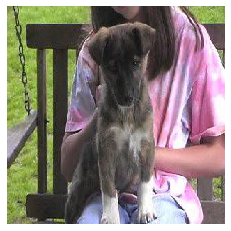

In [ ]:
images_resized = tf.image.resize(images, [224, 224])
plot_color_image(images_resized[0])
plt.show()

#### 이미지의 크기 변환

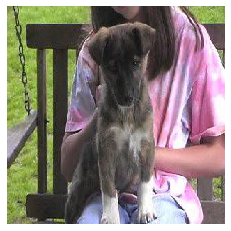

In [ ]:
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True)
plot_color_image(images_resized[0])

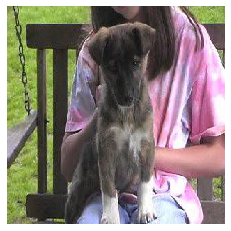

In [ ]:
images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224)
plot_color_image(images_resized[0])
plt.show()

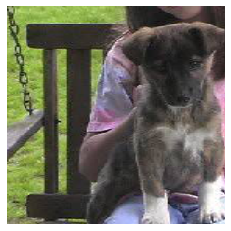

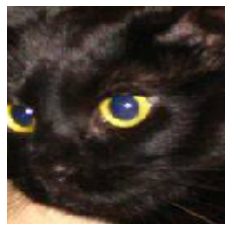

In [ ]:
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

#### 이미지 전처리 수행

In [ ]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
Y_proba = model.predict(inputs)

In [ ]:
Y_proba.shape

(2, 1000)

#### 예측

In [ ]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)

for image_index in range(2):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

Image #0
  n02091467 - Norwegian_elkhound 44.79%
  n02105412 - kelpie       10.78%
  n02106166 - Border_collie 9.05%

Image #1
  n02124075 - Egyptian_cat 63.27%
  n02123159 - tiger_cat    10.71%
  n02123045 - tabby        9.65%



### 위성 이미지 분류

#### 라이브러리 import

In [ ]:
import json
# Tensorflow Datasets 활용
import tensorflow_datasets as tfds

#### 데이터 로드

In [ ]:
#EuroSAT  위성 사진 데이터셋 로드
DATA_DIR = "./data/"

(train_ds, valid_ds), info = tfds.load('eurosat/rgb', split=['train[:80%]', 'train[80%:]'],
                                        shuffle_files=True,
                                        as_supervised=True,
                                        with_info=True,
                                        data_dir=DATA_DIR)
print(train_ds)
print(valid_ds)

<_OptionsDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_OptionsDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


#### 메타데이터 확인

In [ ]:
print(info)

tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_path='./data/eurosat/rgb/2.0.0',
    download_size=89.91 MiB,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disab

#### 샘플 데이터 확인

2022-04-17 18:54:19.634447: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


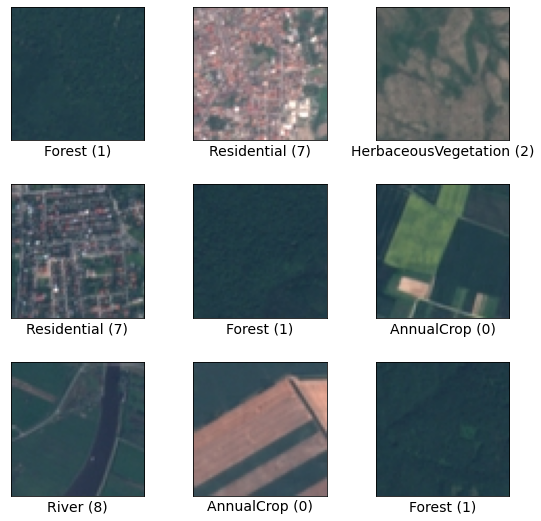

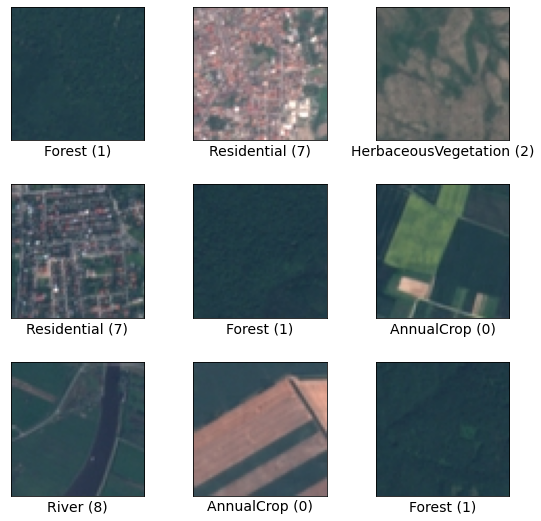

In [ ]:
tfds.show_examples(train_ds, info)

#### dataframe으로 변환해서 샘플 출력

2022-04-17 18:54:20.210938: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


image  label
0  [[[56, 84, 121], [56, 85, 119], [67, 94, 124],...      5
1  [[[102, 105, 112], [105, 104, 110], [116, 107,...      7
2  [[[82, 98, 97], [83, 97, 97], [86, 97, 99], [9...      0
3  [[[56, 72, 87], [56, 72, 87], [52, 70, 82], [5...      1
4  [[[219, 154, 126], [218, 153, 125], [220, 154,...      0
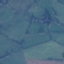
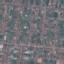
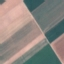
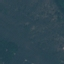
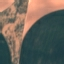

In [ ]:
tfds.as_dataframe(valid_ds.take(5), info)

#### 타겟 클래스의 개수

In [ ]:
NUM_CLASSES = info.features["label"].num_classes
print(NUM_CLASSES)

10


#### 숫자 레이블을 활용하여 문자열 메타데이터로 변환

In [ ]:
for i in range(10):
    print(info.features["label"].int2str(i))

AnnualCrop
Forest
HerbaceousVegetation
Highway
Industrial
Pasture
PermanentCrop
Residential
River
SeaLake


#### 데이터 전처리 파이프라인

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

def preprocess_data(image, label):
    image = tf.cast(image, tf.float32) / 255.   # 0~1 정규화, float32 변환
    return image, label

train_data = train_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
valid_data = valid_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_data = valid_data.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

#### 모델 생성

In [ ]:
# Sequential API를 사용하여 샘플 모델 생성
def build_model():

    model = tf.keras.Sequential([

        # Convolution 층
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        # Classifier 출력층
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'),
    ])

    return model

model = build_model()

#### 모델 컴파일 및 훈련

In [ ]:
# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=50)

Epoch 1/50
338/338 [==============================] - 55s 162ms/step - loss: 1.6059 - accuracy: 0.4315 - val_loss: 1.8513 - val_accuracy: 0.3787
Epoch 2/50
338/338 [==============================] - 55s 163ms/step - loss: 1.2019 - accuracy: 0.5771 - val_loss: 0.9607 - val_accuracy: 0.6502
Epoch 3/50
338/338 [==============================] - 55s 163ms/step - loss: 1.0316 - accuracy: 0.6331 - val_loss: 0.7947 - val_accuracy: 0.7354
Epoch 4/50
338/338 [==============================] - 59s 174ms/step - loss: 0.9456 - accuracy: 0.6690 - val_loss: 0.7090 - val_accuracy: 0.7715
Epoch 5/50
338/338 [==============================] - 62s 183ms/step - loss: 0.8298 - accuracy: 0.7097 - val_loss: 0.6505 - val_accuracy: 0.7928
Epoch 6/50
338/338 [==============================] - 63s 187ms/step - loss: 0.7820 - accuracy: 0.7321 - val_loss: 0.6391 - val_accuracy: 0.7800
Epoch 7/50
338/338 [==============================] - 61s 179ms/step - loss: 0.7326 - accuracy: 0.7511 - val_loss: 0.5566 - val_ac

#### 손실함수, 정확도 그래프 그리기

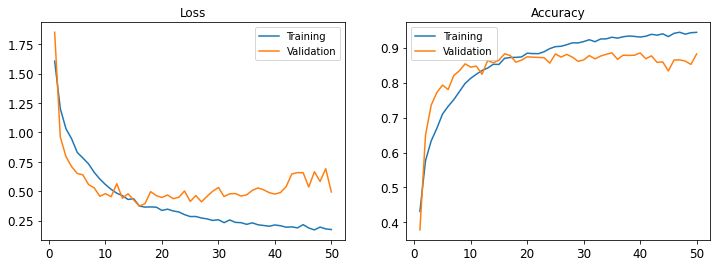

In [ ]:
def plot_loss_acc(history, epoch):

    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(range(1, epoch + 1), loss, label='Training')
    axes[0].plot(range(1, epoch + 1), val_loss, label='Validation')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')

    axes[1].plot(range(1, epoch + 1), acc, label='Training')
    axes[1].plot(range(1, epoch + 1), val_acc, label='Validation')
    axes[1].legend(loc='best')
    axes[1].set_title('Accuracy')

    plt.show()

plot_loss_acc(history, 50)

#### 데이터 증강

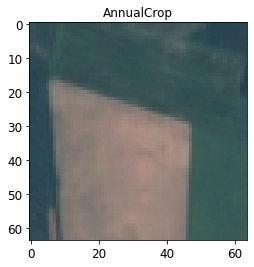

In [ ]:
# 샘플 이미지 출력
image_batch, label_batch = next(iter(train_data.take(1)))

image = image_batch[0]
label = label_batch[0].numpy()

plt.imshow(image)
plt.title(info.features["label"].int2str(label));

In [ ]:
# 데이터 증강 전후를 비교하는 시각화 함수를 정의
def plot_augmentation(original, augmented):

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].imshow(original)
    axes[0].set_title('Original')

    axes[1].imshow(augmented)
    axes[1].set_title('Augmented')

    plt.show()

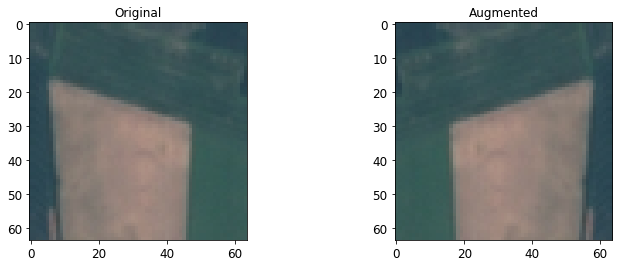

In [ ]:
# 좌우 뒤집기
lr_flip = tf.image.flip_left_right(image)
plot_augmentation(image, lr_flip)

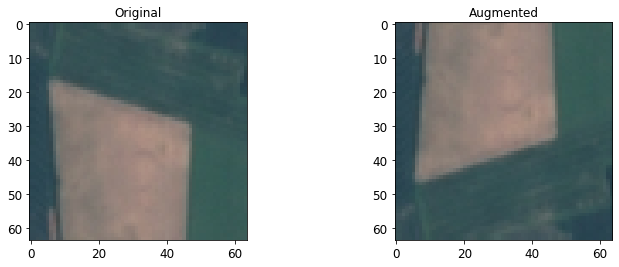

In [ ]:
# 상하 뒤집기
ud_flip = tf.image.flip_up_down(image)
plot_augmentation(image, ud_flip)

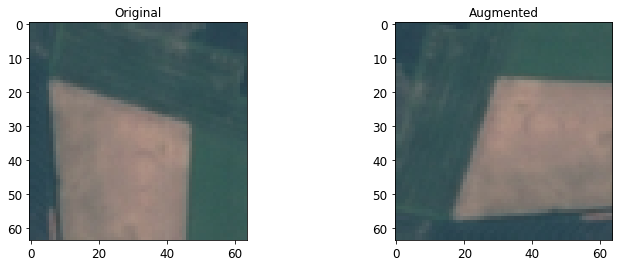

In [ ]:
# 회전
rotate90 = tf.image.rot90(image)
plot_augmentation(image, rotate90)

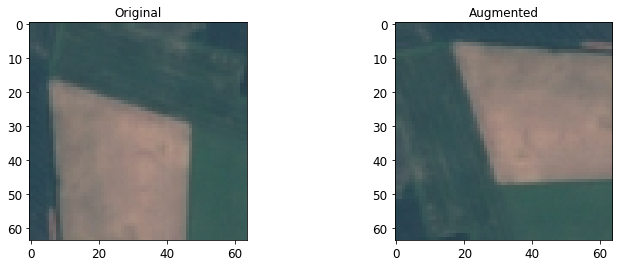

In [ ]:
# transpose
transpose = tf.image.transpose(image)
plot_augmentation(image, transpose)

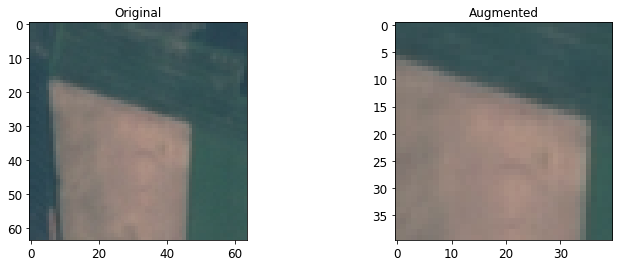

In [ ]:
# 이미지 자르기 1
crop1 = tf.image.central_crop(image, central_fraction=0.6)
plot_augmentation(image, crop1)

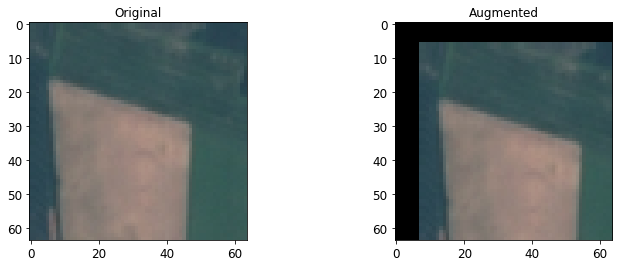

In [ ]:
# 이미지 자르기 2
img = tf.image.resize_with_crop_or_pad(image, 64 + 20, 64 + 20) # 사이즈 키우기
crop2 = tf.image.random_crop(img, size=[64, 64, 3])
plot_augmentation(image, crop2)

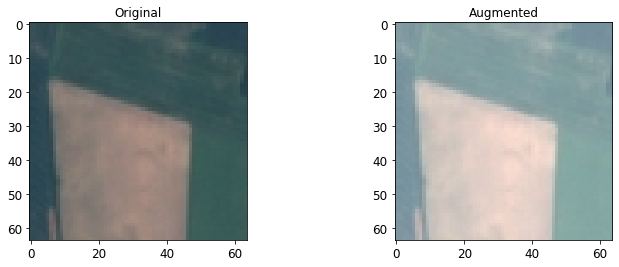

In [ ]:
# 이미지 밝기
brightness = tf.image.adjust_brightness(image, delta=0.3)
plot_augmentation(image, brightness)

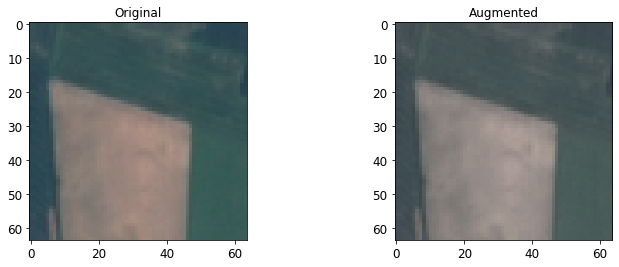

In [ ]:
# 이미지 채도
saturation = tf.image.adjust_saturation(image, saturation_factor=0.5)
plot_augmentation(image, saturation)

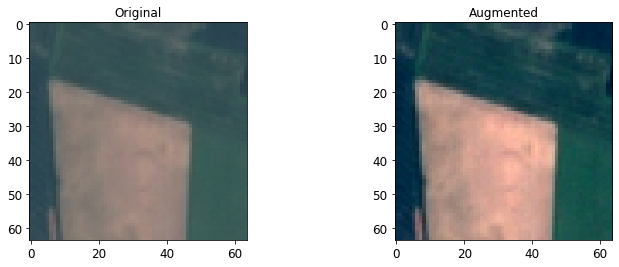

In [ ]:
# 이미지 대비
contrast = tf.image.adjust_contrast(image, contrast_factor=2)
plot_augmentation(image, contrast)

#### 이미지 증강 전처리

In [ ]:
def data_augmentation(image, label):

    image = tf.image.random_flip_left_right(image) # 좌우 반전
    image = tf.image.random_flip_up_down(image) # 상하 반전
    image = tf.image.random_brightness(image, max_delta=0.3) # 밝기 변화
    image = tf.image.random_crop(image, size=[64, 64, 3])

    image = tf.cast(image, tf.float32) / 255.   # 0~1 정규화

    return image, label

train_aug = train_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
valid_aug = valid_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

train_aug = train_aug.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_aug = valid_aug.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

print(train_aug)
print(valid_aug)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


#### 이미지 증강 후 모델 생성 과 훈련

In [ ]:
# 모델 생성
aug_model = build_model()

# 모델 컴파일
aug_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)

# 모델 훈련
aug_history = aug_model.fit(train_aug,
                            validation_data=valid_aug,
                            epochs=50,
                            callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/50
338/338 [==============================] - 56s 163ms/step - loss: 1.8936 - accuracy: 0.3189 - val_loss: 1.6817 - val_accuracy: 0.4002
Epoch 2/50
338/338 [==============================] - 54s 159ms/step - loss: 1.5164 - accuracy: 0.4449 - val_loss: 1.2729 - val_accuracy: 0.5391
Epoch 3/50
338/338 [==============================] - 54s 159ms/step - loss: 1.3364 - accuracy: 0.5238 - val_loss: 1.2187 - val_accuracy: 0.5765
Epoch 4/50
338/338 [==============================] - 54s 159ms/step - loss: 1.2009 - accuracy: 0.5756 - val_loss: 1.0391 - val_accuracy: 0.6354
Epoch 5/50
338/338 [==============================] - 54s 159ms/step - loss: 1.0946 - accuracy: 0.6152 - val_loss: 0.9041 - val_accuracy: 0.6791
Epoch 6/50
338/338 [==============================] - 54s 159ms/step - loss: 1.0180 - accuracy: 0.6462 - val_loss: 0.8809 - val_accuracy: 0.6978
Epoch 7/50
338/338 [==============================] - 54s 158ms/step - loss: 0.9793 - accuracy: 0.6573 - val_loss: 0.7892 - val_ac

#### 손실함수, 정확도 그래프 그리기

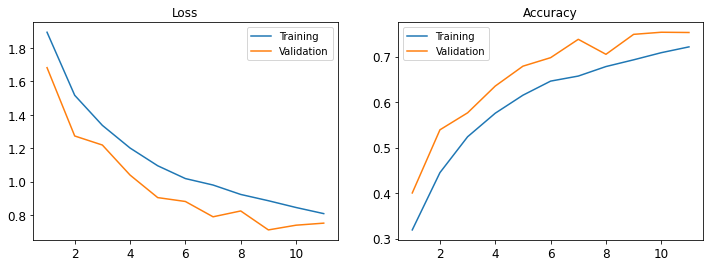

In [ ]:
plot_loss_acc(aug_history, 11)

### 위성 이미지 분류 - 사전 학습된 모델을 이용한 훈련

#### Pre-trained 모델을 사전 학습된 가중치와 함께 가져오기

In [ ]:
from tensorflow.keras.applications import ResNet50V2

pre_trained_base = ResNet50V2(include_top=False,
                               weights='imagenet',
                               input_shape=[64, 64, 3])
,
# 사전 학습된 가중치를 업데이트 되지 않도록 설정
pre_trained_base.trainable = False

# 모델 구조 시각화
keras.utils.plot_model(pre_trained_base, show_shapes=True, show_layer_names=True, to_file='resnet50.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


#### 모델 생성

In [ ]:
# Top 층에 Classifier 추가
def build_trainsfer_classifier():

    model = tf.keras.Sequential([

        # Pre-trained Base
        pre_trained_base,
        # Classifier 출력층
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'),
    ])

    return model

# 모델 구조
tc_model = build_trainsfer_classifier()
tc_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 flatten_12 (Flatten)        (None, 8192)              0         
                                                                 
 dense_23 (Dense)            (None, 128)               1048704   
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_24 (Dense)            (None, 64)                8256      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_25 (Dense)            (None, 10)               

#### 모델 컴파일 및 훈련

In [ ]:
# 모델 컴파일
tc_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)
# 모델 훈련
tc_history = tc_model.fit(train_aug,
                          validation_data=valid_aug,
                          epochs=50,
                          callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/50
338/338 [==============================] - 109s 318ms/step - loss: 1.0223 - accuracy: 0.6692 - val_loss: 0.6128 - val_accuracy: 0.8028
Epoch 2/50
338/338 [==============================] - 103s 303ms/step - loss: 0.7092 - accuracy: 0.7729 - val_loss: 0.5408 - val_accuracy: 0.8220
Epoch 3/50
338/338 [==============================] - 100s 295ms/step - loss: 0.6183 - accuracy: 0.8024 - val_loss: 0.4977 - val_accuracy: 0.8343
Epoch 4/50
338/338 [==============================] - 99s 294ms/step - loss: 0.5617 - accuracy: 0.8184 - val_loss: 0.4855 - val_accuracy: 0.8413
Epoch 5/50
338/338 [==============================] - 98s 291ms/step - loss: 0.5279 - accuracy: 0.8275 - val_loss: 0.4703 - val_accuracy: 0.8435
Epoch 6/50
338/338 [==============================] - 98s 289ms/step - loss: 0.5049 - accuracy: 0.8362 - val_loss: 0.4683 - val_accuracy: 0.8469
Epoch 7/50
338/338 [==============================] - 98s 289ms/step - loss: 0.4720 - accuracy: 0.8479 - val_loss: 0.4614 - val

#### 손실함수, 정확도 그래프 그리기

ValueError: x and y must have same first dimension, but have shapes (8,) and (10,)

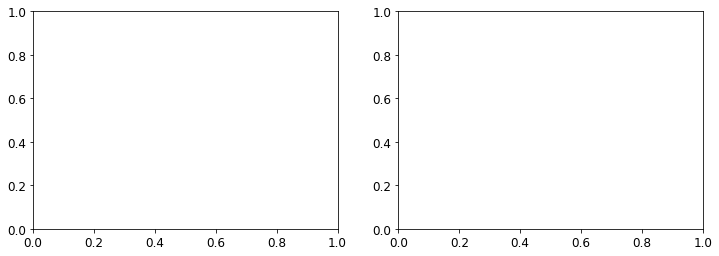

In [ ]:
plot_loss_acc(tc_history, 10)

### Xception 전이학습

#### 데이터 가져오기

In [ ]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

#### 데이터 확인

In [ ]:
info.splits

{'train': <SplitInfo num_examples=3670, num_shards=2>}

In [ ]:
info.splits["train"]

<SplitInfo num_examples=3670, num_shards=2>

In [ ]:
class_names = info.features["label"].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [ ]:
n_classes = info.features["label"].num_classes

In [ ]:
dataset_size = info.splits["train"].num_examples
dataset_size

3670

#### 데이터 셋 분리

In [ ]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

#### 이미지 확인

2022-04-17 20:26:57.914938: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


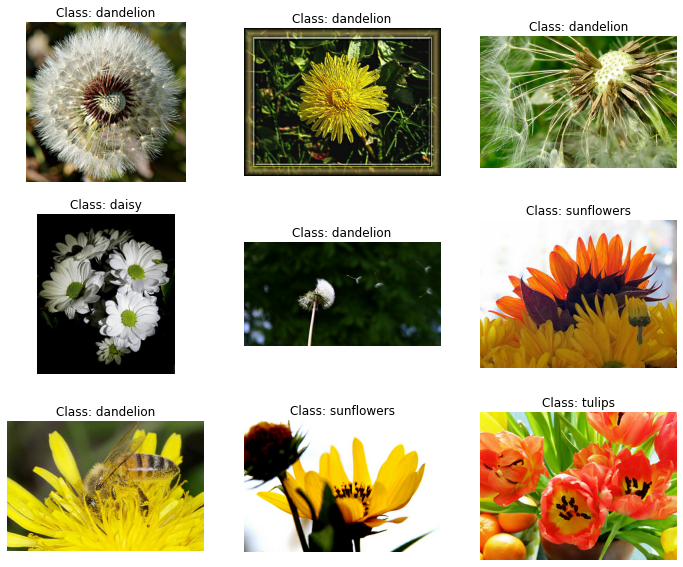

In [ ]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

In [ ]:
from functools import partial

#이미지 전처리 함수
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label


In [ ]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])



In [ ]:
def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

#### 배치 크기 설정 및 프리페치 적용

In [ ]:
batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

#### 이미지 확인

2022-04-17 20:27:05.682168: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


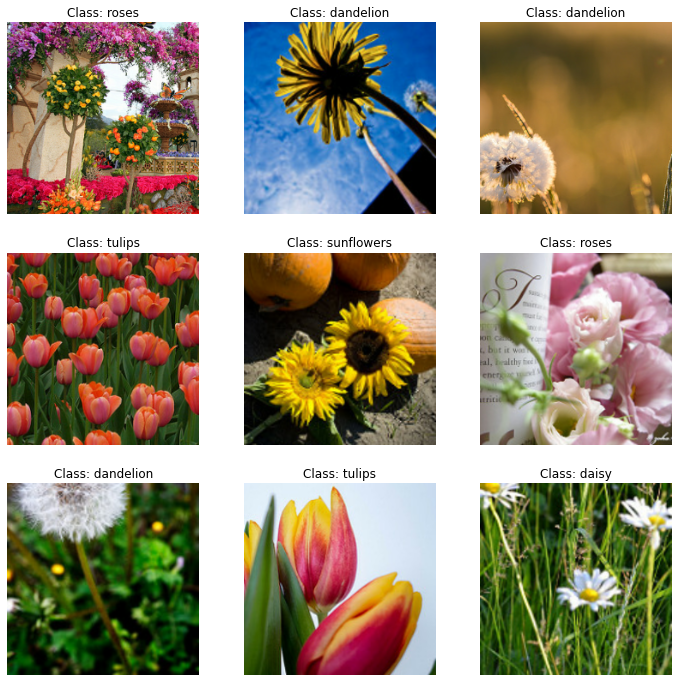

In [ ]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

#### 모델 생성 및 훈련

In [ ]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [ ]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_8
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_20
13 block2_pool
14 batch_normalization_10
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_21
23 block3_pool
24 batch_normalization_11
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_22
33 block4_pool
34 batch_normalization_12
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_se

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
86/86 [==============================] - 184s 2s/step - loss: 0.9665 - accuracy: 0.8078 - val_loss: 1.0715 - val_accuracy: 0.8309
Epoch 2/5
86/86 [==============================] - 175s 2s/step - loss: 0.5500 - accuracy: 0.8932 - val_loss: 0.8015 - val_accuracy: 0.8621
Epoch 3/5
86/86 [==============================] - 175s 2s/step - loss: 0.2807 - accuracy: 0.9270 - val_loss: 0.6960 - val_accuracy: 0.8676
Epoch 4/5
86/86 [==============================] - 175s 2s/step - loss: 0.2027 - accuracy: 0.9433 - val_loss: 0.6461 - val_accuracy: 0.8750
Epoch 5/5
86/86 [==============================] - 175s 2s/step - loss: 0.1521 - accuracy: 0.9473 - val_loss: 0.6510 - val_accuracy: 0.8676


In [ ]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40)

Epoch 1/40
86/86 [==============================] - 37601s 442s/step - loss: 0.3212 - accuracy: 0.8972 - val_loss: 0.4295 - val_accuracy: 0.8750
Epoch 2/40
86/86 [==============================] - 744s 9s/step - loss: 0.1170 - accuracy: 0.9608 - val_loss: 0.2802 - val_accuracy: 0.9154
Epoch 3/40
86/86 [==============================] - 829s 10s/step - loss: 0.0649 - accuracy: 0.9789 - val_loss: 0.3419 - val_accuracy: 0.9081
Epoch 4/40
86/86 [==============================] - 753s 9s/step - loss: 0.0507 - accuracy: 0.9847 - val_loss: 0.2889 - val_accuracy: 0.9062
Epoch 5/40
86/86 [==============================] - 2016s 24s/step - loss: 0.0356 - accuracy: 0.9887 - val_loss: 0.3032 - val_accuracy: 0.9136
Epoch 6/40
86/86 [==============================] - 935s 11s/step - loss: 0.0347 - accuracy: 0.9862 - val_loss: 0.3049 - val_accuracy: 0.9210
Epoch 7/40
86/86 [==============================] - 747s 9s/step - loss: 0.0233 - accuracy: 0.9927 - val_loss: 0.2842 - val_accuracy: 0.9210
Epoch

### InceptionV3, lnceptionResNetV2, Xception 사전 학습 가중치를 이용한 분류

91897856/91884032 [==============================] - 8s 0us/step


InceptionV3, Top-5: [('n03950228', 'pitcher', 0.721977), ('n01924916', 'flatworm', 0.27800524), ('n04522168', 'vase', 1.5433145e-05), ('n03908714', 'pencil_sharpener', 1.8315005e-06), ('n04131690', 'saltshaker', 3.0640618e-07)]
InceptionResNetV2, Top-5: [('n06596364', 'comic_book', 1.0), ('n02791124', 'barber_chair', 7.7977665e-29), ('n04517823', 'vacuum', 2.2254776e-32), ('n15075141', 'toilet_tissue', 0.0), ('n02342885', 'hamster', 0.0)]
Xception, Top-5: [('n03775546', 'mixing_bowl', 0.65605265), ('n03825788', 'nipple', 0.16745344), ('n03763968', 'military_uniform', 0.11219799), ('n03942813', 'ping-pong_ball', 0.050322007), ('n02704792', 'amphibian', 0.003398759)]


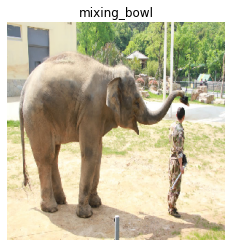

In [ ]:
from tensorflow.keras.applications import InceptionV3, InceptionResNetV2, Xception
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.preprocessing import image # pip install pillow
import numpy as np
import matplotlib.pyplot as plt

#모델 가중치 가져오기
model1 = InceptionV3(weights='imagenet', include_top=True)
model2 = InceptionResNetV2(weights='imagenet', include_top=True)
model3 = Xception(weights='imagenet', include_top=True)

#이미지 예측
img_path = './data/elephant.jpg'
img = image.load_img(img_path, target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0) # (1, 299, 299, 3)
x = preprocess_input(x)
output1 = model1.predict(x)
output2 = model2.predict(x)
output3 = model3.predict(x)

top5 = decode_predictions(output1, top=5)[0]
print('InceptionV3, Top-5:', top5)

top5 = decode_predictions(output2, top=5)[0]
print('InceptionResNetV2, Top-5:', top5)

top5 = decode_predictions(output3, top=5)[0]
print('Xception, Top-5:', top5)

plt.imshow(img)
plt.title(top5[0][1])
plt.axis("off")
plt.show()